In [4]:
import random, glob, cv2, os

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

from keras.models import load_model
from keras import optimizers
from keras import layers
from keras import regularizers
from keras import metrics
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Concatenate, concatenate, Lambda, Dropout, multiply
from keras.callbacks import TensorBoard

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.model_selection import train_test_split

from IPython.display import Image
from tensorflow.keras.utils import plot_model

Using TensorFlow backend.


In [5]:
import keras
keras.__version__

'2.2.2'

The memory has shape: (1, 128)
The data has been loaded, with the shape: (2000, 84, 84, 1)
Loaded image has shape: (84, 84, 1)


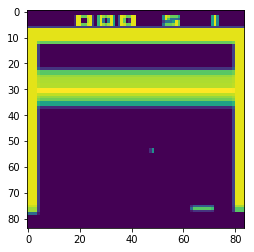

In [3]:
GAME_NAME = "Breakout"
#Due to Keras structuring the data is layout as GameName/Screen/Pixels/All_Images.pngs
IMAGE_LOAD_PATH = f"GameplayData/{GAME_NAME}/Screen"

# Get the files sorted by the order they were modified (created.)

x_mem_train = np.load(f"GameplayData/{GAME_NAME}/Ram/{GAME_NAME}_RAMs.npy")[0:1]
print("The memory has shape:", x_mem_train.shape)

file_names = sorted(glob.glob(f"{IMAGE_LOAD_PATH}/Pixels/*.png"), key=os.path.getmtime)[0:2000]
x_train = np.array([cv2.imread(file) for file in file_names])
x_train = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in x_train])


# Deepmind DownSampling
x_train = np.array([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in x_train])
x_train = np.array([cv2.resize(image, (84, 84), interpolation=cv2.INTER_AREA) for image in x_train])
x_train = x_train.reshape(len(x_train), 84, 84, 1)
print("The data has been loaded, with the shape:", x_train.shape)

random.choice(x_train)
random_image = x_train[0]
IMAGE_SHAPE = np.array(random_image).shape
print("Loaded image has shape:",IMAGE_SHAPE )
plt.imshow(random_image.squeeze())


The max and min value of the x_train are: 0.580392156862745 0.0


TypeError: Invalid dimensions for image data

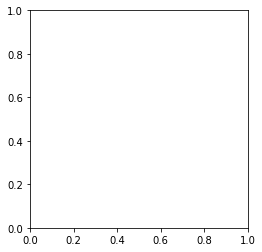

In [3]:
x_train = x_train * (1./255)
x_train, x_test = x_train[:9900], x_train[9900:]
x_mem_train = x_mem_train * (1./255)
x_mem_train, x_mem_test =  x_mem_train[:9900], x_mem_train[9900:]

assert np.max(x_train) <= 1 and np.min(x_train) >= 0, "The normalization went wrong!"
assert np.max(x_mem_train) <= 1 and np.min(x_mem_train) >= 0, "The normalization went wrong!"
print("The max and min value of the x_train are:", np.max(x_train),np.min(x_train))

plt.imshow(random.choice(x_train))
print("The memory example", x_mem_train[0])
print("The training shape:", x_train.shape)
# print("The testing shape:", x_test.shape)

The first frame shape: (97, 210, 160, 3)
The second frame shape: (97, 210, 160, 3)
The prediction frame shape: (97, 210, 160, 3)
The memory has shape: (97, 128)
The memory example [0.24705882 0.24705882 0.24705882 0.24705882 0.24705882 0.24705882
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.75294118 0.75294118 0.75294118 0.75294118 0.75294118 0.75294118
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.94117647 0.         0.         1.         0.
 0.         0.94117647 0.         0.01960784 0.         0.
 0.02352941 0.         0.2745098  0.71372549 0.5254902  0.77647059
 0.08627451 0.14901961 0.21176471 0.2745098  0.25882353 0.00392157
 0.65882353 0.         0.00784314 0.03921569 0.         0.
 0.         0.       

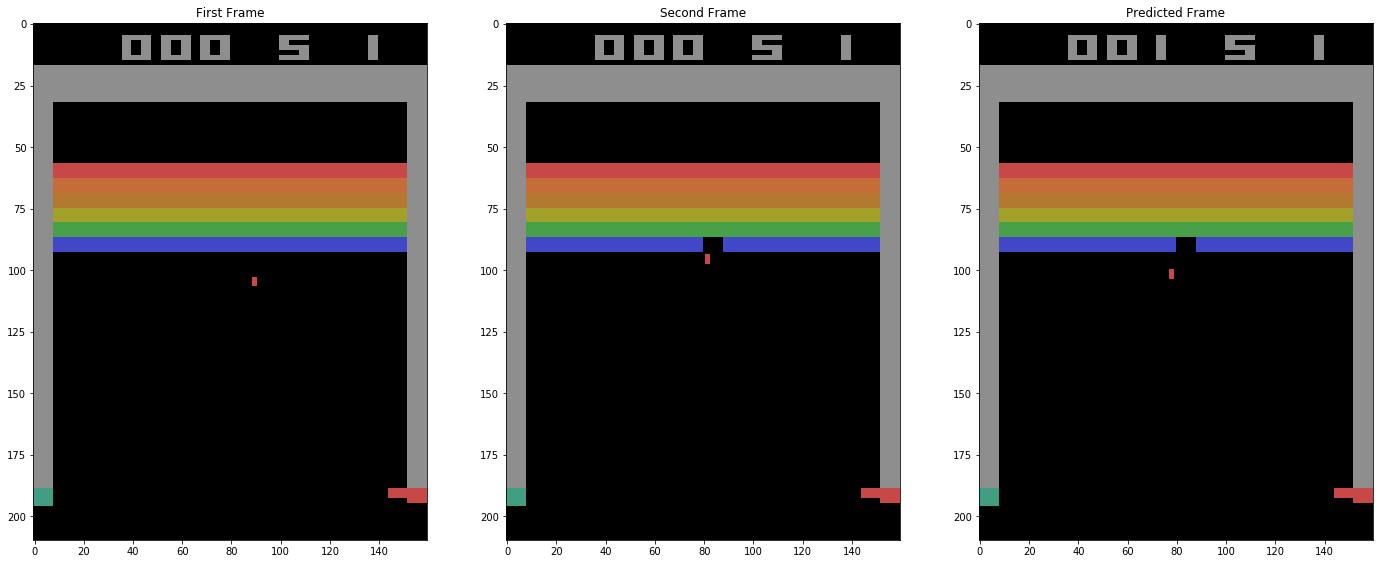

In [9]:
num_data_points = len(x_train)

frame_delta = 2
first_frame_x = x_train[0:num_data_points - frame_delta -1] 
second_frame_x = x_train[frame_delta: num_data_points - 1] 
frame_y = x_train[(frame_delta + 1): num_data_points] 

first_frame_memory = x_mem_train[0:num_data_points - frame_delta -1] 
print("The first frame shape:", first_frame_x.shape)
print("The second frame shape:", second_frame_x.shape)
print("The prediction frame shape:", frame_y.shape)
print("The memory has shape:", first_frame_memory.shape)

print("The memory example", first_frame_memory[0])
assert (first_frame_x.shape) == (second_frame_x.shape) == (frame_y.shape), "All the arrays should be the same shape!"

frame_to_show = 27

fig=plt.figure(figsize=(24, 12))
ax = plt.subplot(1, 3, 1)
plt.imshow(first_frame_x[frame_to_show])
plt.title("First Frame")

ax = plt.subplot(1, 3, 2)
plt.title("Second Frame")
plt.imshow(second_frame_x[frame_to_show])

ax = plt.subplot(1, 3, 3)
plt.title("Predicted Frame")
plt.imshow(frame_y[frame_to_show])

THESE SHOULD BE THE SAME!


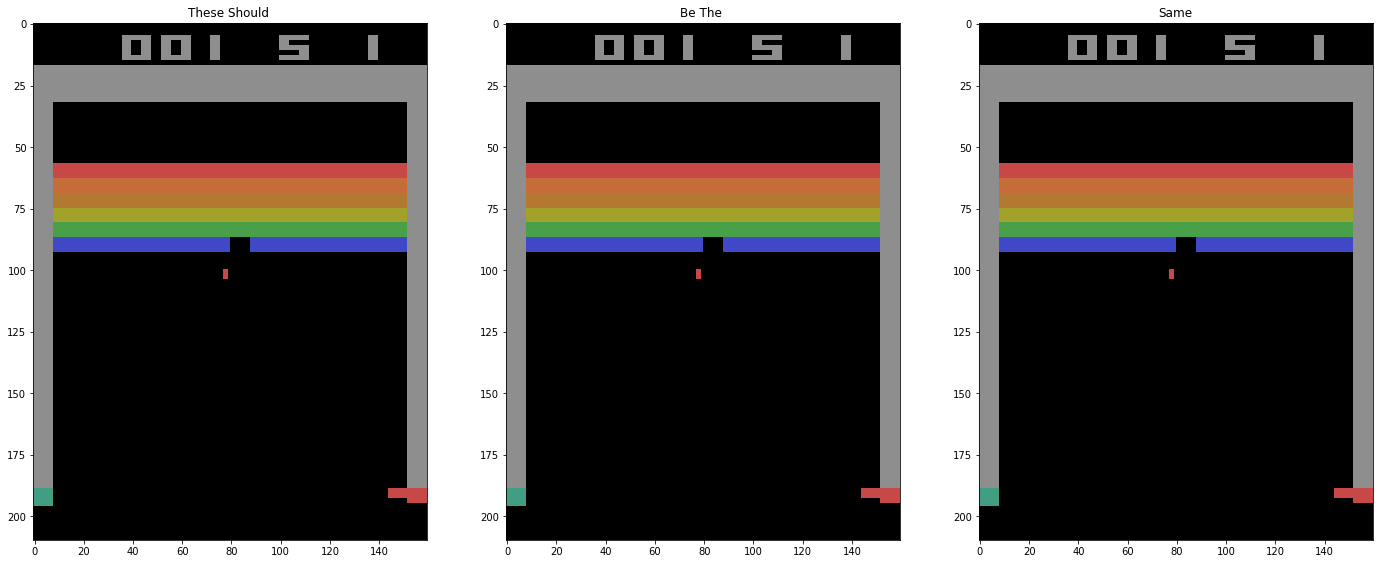

In [10]:
assert (first_frame_x[frame_to_show + frame_delta] == second_frame_x[frame_to_show]).all(), "The frames are not identical! The ordering might be wrong"

fig=plt.figure(figsize=(24, 12))
ax = plt.subplot(1, 3, 1)
plt.imshow(first_frame_x[frame_to_show + frame_delta + 1])
plt.title("These Should ")
ax = plt.subplot(1, 3, 2)
plt.title("Be The ")
plt.imshow(second_frame_x[frame_to_show + 1])
ax = plt.subplot(1, 3, 3)
plt.title("Same")
plt.imshow(frame_y[frame_to_show])

print("THESE SHOULD BE THE SAME!")

In [6]:
def test_autoencoder(model):
    decoded_imgs = model.predict(x_train)
    print(decoded_imgs.shape)
    n = 10
    plt.figure(figsize=(80, 16))
    for i in range(1, n):
        # display original
        ax = plt.subplot(2, n, i)
        plt.imshow(x_train[i].reshape(210, 160, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + n)
        plt.imshow(decoded_imgs[i].reshape(210, 160, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# A --> A

In [11]:
input_img = Input(shape=IMAGE_SHAPE)  # adapt this if using `channels_first` image data format

padding_x = int((256 - IMAGE_SHAPE[0]) / 2)
padding_y = int((256 - IMAGE_SHAPE[1]) / 2)

x = layers.ZeroPadding2D(padding=(padding_x, padding_y))(input_img)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.AveragePooling2D((4, 4), padding='same')(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.AveragePooling2D((4, 4), padding='same')(x)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.AveragePooling2D((2, 2), padding='same')(x)
print(x.shape)
encoded = layers.Flatten(name="bottleneck")(x)

x = layers.Reshape((8, 8, 8))(encoded)

x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (4, 4), activation='relu', padding='same')(x)

x = layers.UpSampling2D((4, 4))(x)
x = layers.Conv2D(64, (4, 4), activation='relu', padding='same')(x)

x = layers.UpSampling2D((4, 4))(x)
x = layers.Conv2D(3, (5, 5), activation='sigmoid', padding='same')(x)

decoded = layers.Cropping2D(cropping=(padding_x, padding_y))(x)

encoder = Model(input_img, encoded)
autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')
autoencoder.summary()


(?, 8, 8, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 210, 160, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
average_pooling2d_1 (Average (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
average_pooling2d_2 (Average (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 8)         4616    

In [5]:
autoencoder.fit(x_train, x_train, epochs=5)

Epoch 1/5
9900/9900 [==============================] - 86s 9ms/step - loss: 0.2329
Epoch 2/5
9900/9900 [==============================] - 75s 8ms/step - loss: 0.1926
Epoch 3/5
9900/9900 [==============================] - 75s 8ms/step - loss: 0.1896
Epoch 4/5
9900/9900 [==============================] - 75s 8ms/step - loss: 0.1881
Epoch 5/5
9900/9900 [==============================] - 75s 8ms/step - loss: 0.1870


In [6]:
encoder.summary()
encoder.save("breakout_averagepix2pix_512")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 210, 160, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
average_pooling2d_1 (Average (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
average_pooling2d_2 (Average (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 8)         4616      
__________

(10, 210, 160, 3)
(10, 210, 160, 3)


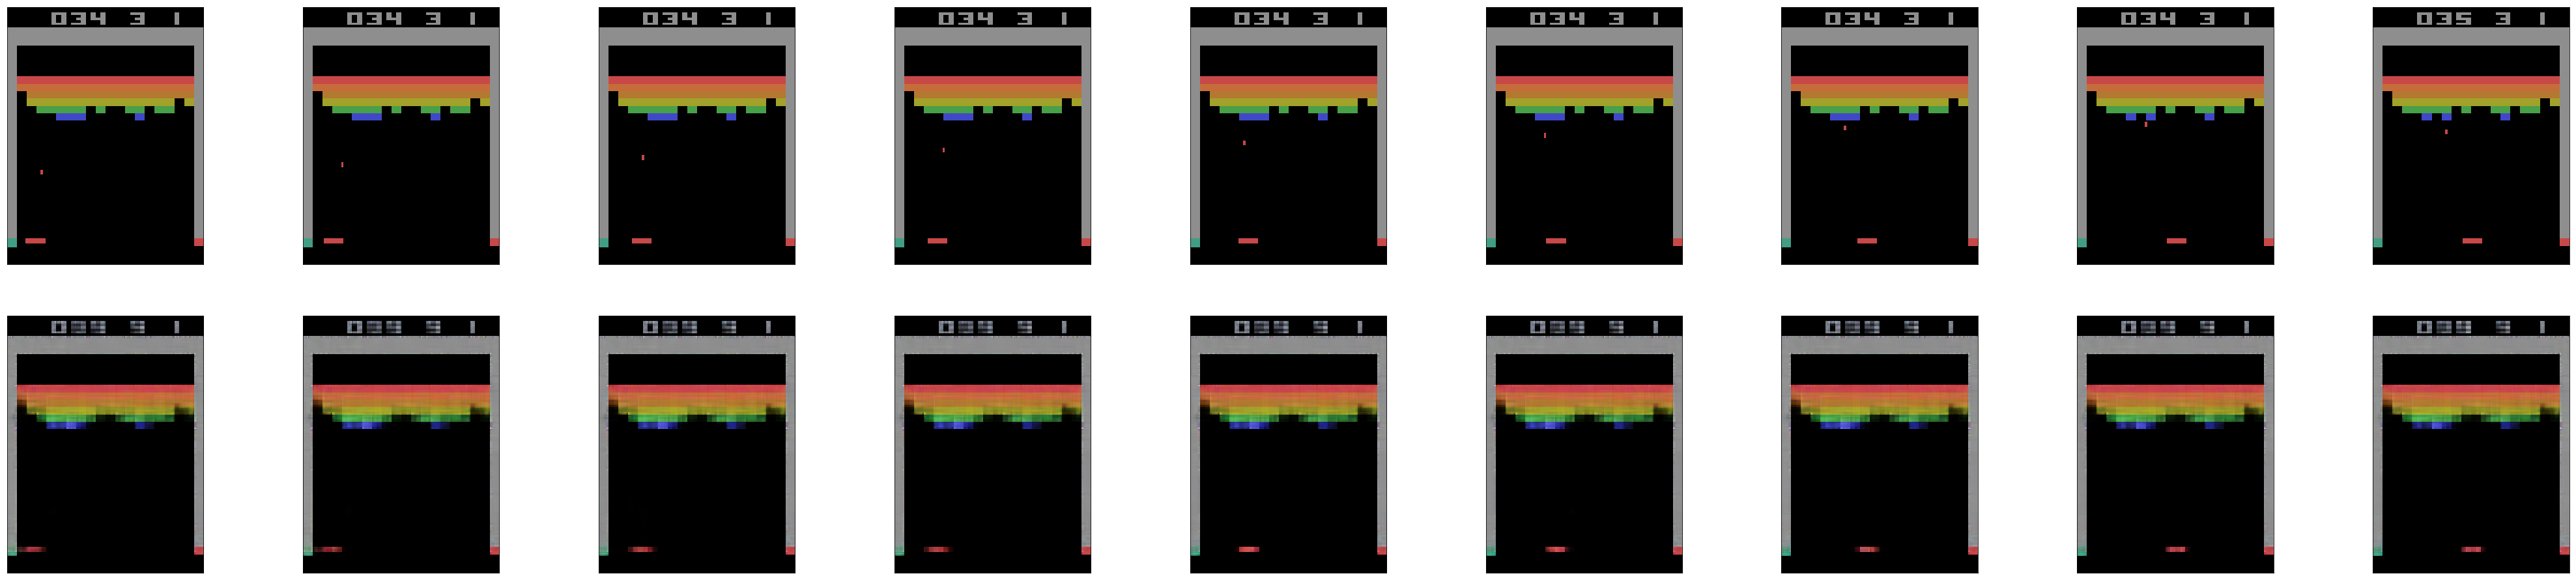

In [7]:
predict_start_state = 50
decoded_imgs = autoencoder.predict(x_test[predict_start_state:predict_start_state+10])
print(np.array(decoded_imgs).shape)
print(decoded_imgs.shape)
n = 10
plt.figure(figsize=(80, 16))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[predict_start_state:predict_start_state+10][i].reshape(210, 160, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(210, 160, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [44]:
encoder.save("breakout_pix2pix_bw.h5")
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 84, 84, 1)         0         
_________________________________________________________________
zero_padding2d_21 (ZeroPaddi (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 128, 128, 64)      640       
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 32, 32, 8)         4616      
__________

## AD --> E

In [10]:
input_one = Input(shape=IMAGE_SHAPE)  # adapt this if using `channels_first` image data format
input_two = Input(shape=IMAGE_SHAPE)

padding_x = int((256 - IMAGE_SHAPE[0]) / 2)
padding_y = int((256 - IMAGE_SHAPE[1]) / 2)

x = layers.ZeroPadding2D(padding=(padding_x, padding_y))(input_one)

x = layers.Conv2D(64, (5, 5), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((4, 4), padding='same')(x)

x = layers.Conv2D(64, (4, 4), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((4, 4), padding='same')(x)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((4, 4), padding='same')(x)

input_one_encoding = layers.Flatten(name="bottlneck_one")(x)

######################################################################

x = layers.ZeroPadding2D(padding=(padding_x, padding_y))(input_two)

x = layers.Conv2D(64, (5, 5), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((4, 4), padding='same')(x)

x = layers.Conv2D(64, (4, 4), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((4, 4), padding='same')(x)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((4, 4), padding='same')(x)

input_two_encoding = layers.Flatten(name="bottlneck_two")(x)

#####################################################################

bottleneck_layer = layers.concatenate([input_one_encoding, input_two_encoding])

x = layers.Reshape((4, 4, 16))(bottleneck_layer)

x = layers.UpSampling2D((4, 4))(x)
x = layers.Conv2D(64, (4, 4), activation='relu', padding='same')(x)

x = layers.UpSampling2D((4, 4))(x)
x = layers.Conv2D(64, (4, 4), activation='relu', padding='same')(x)

x = layers.UpSampling2D((4, 4))(x)
x = layers.Conv2D(3, (5, 5), activation='sigmoid', padding='same')(x)

decoded = layers.Cropping2D(cropping=(padding_x, padding_y))(x)

encoder = Model(inputs=[input_one, input_two], outputs=[bottleneck_layer])
autopredictor = Model([input_one, input_two], decoded)

autopredictor.compile(optimizer='Adam', loss='binary_crossentropy')
autopredictor.summary()

# plot_model(autopredictor)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 210, 160, 3)  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 210, 160, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 256, 256, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 256, 256, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_18 

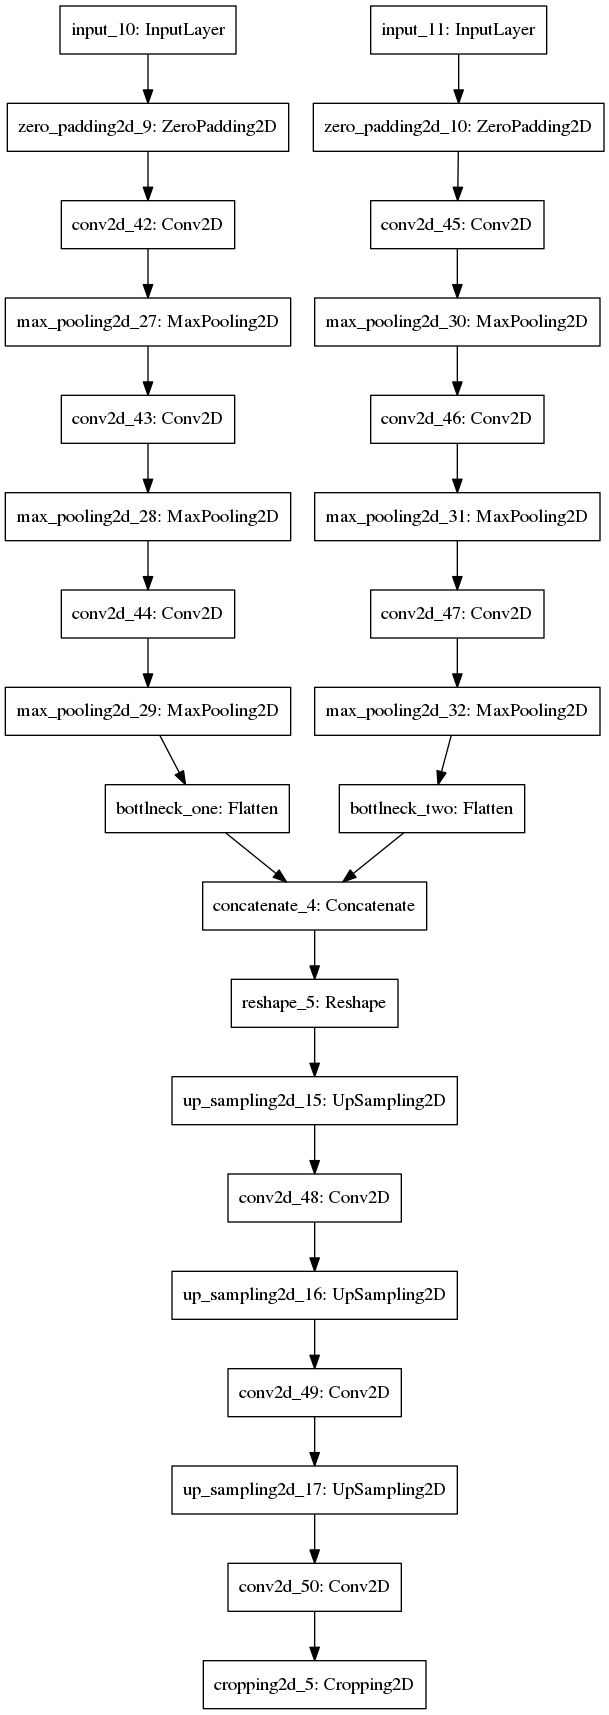

In [8]:
Image(retina=True, filename='model.png')

In [11]:
autopredictor.fit(x=[first_frame_x, second_frame_x],y=frame_y, epochs=10)

Epoch 1/10
9997/9997 [==============================] - 104s 10ms/step - loss: 7.4518
Epoch 2/10
9997/9997 [==============================] - 101s 10ms/step - loss: 6.1965
Epoch 3/10
9997/9997 [==============================] - 103s 10ms/step - loss: 6.1149
Epoch 4/10
9997/9997 [==============================] - 103s 10ms/step - loss: 6.0666
Epoch 5/10
9997/9997 [==============================] - 101s 10ms/step - loss: 6.0317
Epoch 6/10
9997/9997 [==============================] - 101s 10ms/step - loss: 6.0065
Epoch 7/10
9997/9997 [==============================] - 100s 10ms/step - loss: 5.9854
Epoch 8/10
9997/9997 [==============================] - 102s 10ms/step - loss: 5.9687
Epoch 9/10
9997/9997 [==============================] - 101s 10ms/step - loss: 5.9512
Epoch 10/10
9997/9997 [==============================] - 101s 10ms/step - loss: 5.9400


(10, 210, 160, 3)


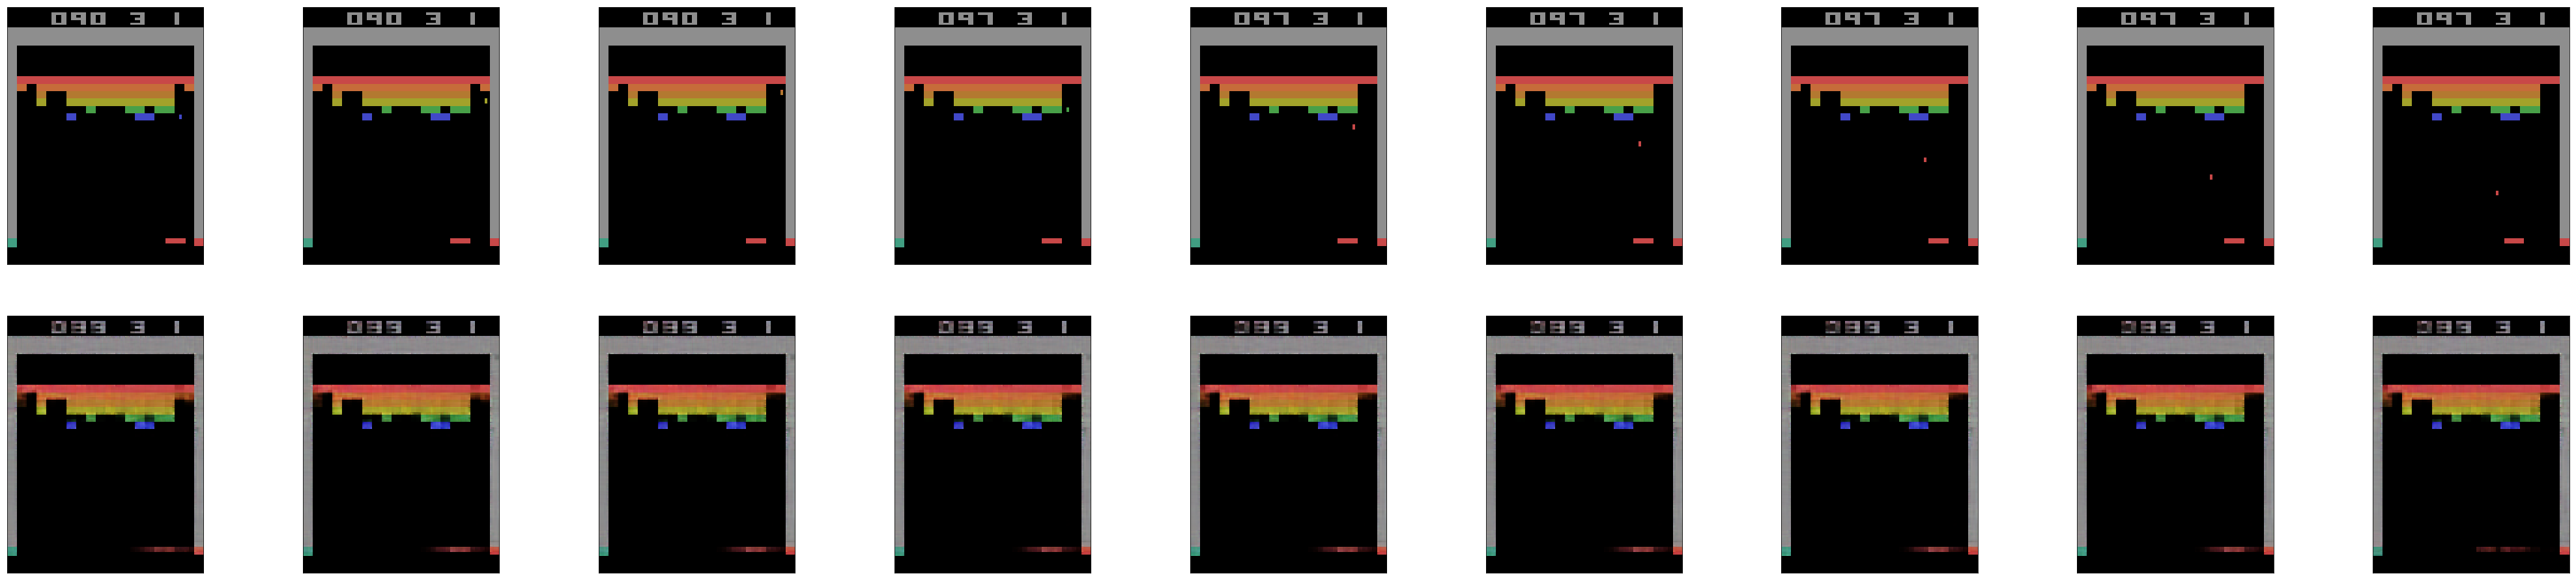

In [40]:
predict_start_state = 1250
decoded_imgs = autopredictor.predict([first_frame_x[predict_start_state:predict_start_state+10], 
                                      second_frame_x[predict_start_state:predict_start_state+10]])
print(decoded_imgs.shape)
n = 10
plt.figure(figsize=(80, 16))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(second_frame_x[predict_start_state:predict_start_state+10][i].reshape(210, 160, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(210, 160, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

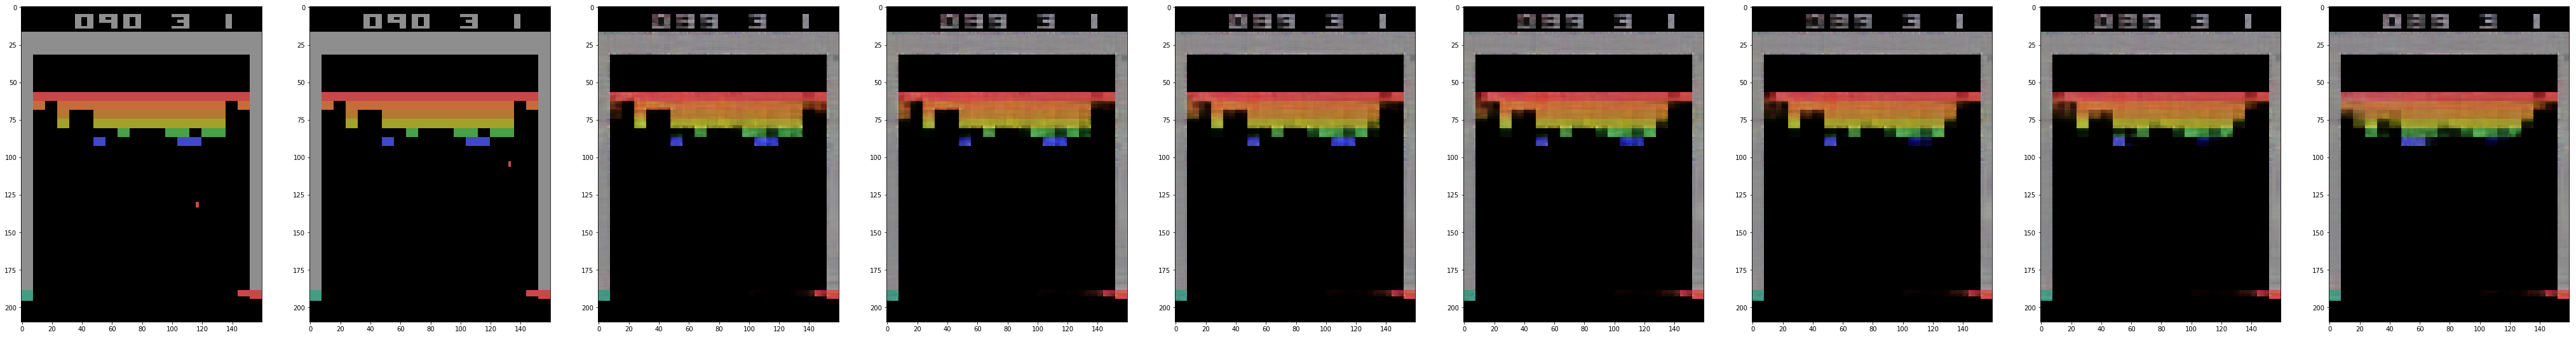

In [42]:
frame_1 = first_frame_x[1250]
frame_2 = second_frame_x[1250]

plt.figure(figsize=(80, 16))

ax = plt.subplot(1, 10, 1)
plt.imshow(frame_1)
ax = plt.subplot(1, 10, 2)
plt.imshow(frame_2)

for i in range(3, 10):
    prediction = autopredictor.predict([frame_1[None], frame_2[None]]).squeeze()
    ax = plt.subplot(1, 10, i)
    plt.imshow(prediction)
    frame_1, frame_2 = frame_2, prediction
    

In [13]:
encoder.summary()
encoder.save('Models/Breakout/breakout_pixab2c.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 210, 160, 3)  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 210, 160, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 256, 256, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 256, 256, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_18 

## AB --> C Shared

In [12]:
input_image = Input(shape=IMAGE_SHAPE)  # adapt this if using `channels_first` image data format

padding_x = int((256 - IMAGE_SHAPE[0]) / 2)
padding_y = int((256 - IMAGE_SHAPE[1]) / 2)

input_image = Input(shape=IMAGE_SHAPE)

x = layers.ZeroPadding2D(padding=(padding_x, padding_y))(input_image)

x = layers.Conv2D(64, (5, 5), activation='elu', padding='same')(x)
x = layers.MaxPooling2D((4, 4), padding='same')(x)

x = layers.Conv2D(64, (4, 4), activation='elu', padding='same')(x)
x = layers.MaxPooling2D((4, 4), padding='same')(x)

x = layers.Conv2D(8, (3, 3), activation='elu', padding='same')(x)
x = layers.MaxPooling2D((4, 4), padding='same')(x)

input_encoding = layers.Flatten(name="bottlneck_one")(x)

feature_extractor = Model(input_image, input_encoding)

#####################################################################

input_1 = Input(shape=IMAGE_SHAPE)
input_2 = Input(shape=IMAGE_SHAPE)

extracted_features_1 = feature_extractor(input_1)
extracted_features_2 = feature_extractor(input_2)

bottleneck_layer = layers.concatenate([extracted_features_1, extracted_features_2])

x = layers.Reshape((4, 4, 16))(bottleneck_layer)

x = layers.UpSampling2D((4, 4))(x)
x = layers.Conv2D(64, (4, 4), activation='elu', padding='same')(x)

x = layers.UpSampling2D((4, 4))(x)
x = layers.Conv2D(64, (4, 4), activation='elu', padding='same')(x)

x = layers.UpSampling2D((4, 4))(x)
x = layers.Conv2D(3, (5, 5), activation='sigmoid', padding='same')(x)

decoded = layers.Cropping2D(cropping=(padding_x, padding_y))(x)

encoder = Model(inputs=[input_1, input_2], outputs=[bottleneck_layer])
autopredictor = Model([input_1, input_2], decoded)

autopredictor.compile(optimizer='Adam', loss='binary_crossentropy')
autopredictor.summary()

plot_model(autopredictor)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 210, 160, 3)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 210, 160, 3)  0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 128)          75080       input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 256)          0           model_3[1][0]                    
          

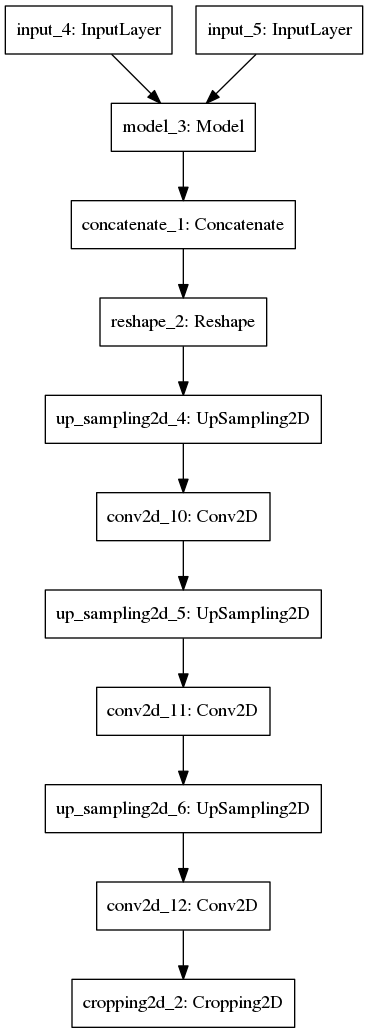

In [13]:
Image(retina=True, filename='model.png')

In [9]:
autopredictor.fit(x=[first_frame_x, second_frame_x],y=frame_y, epochs=10)

Epoch 1/10
9997/9997 [==============================] - 119s 12ms/step - loss: 9.1064
Epoch 2/10
9997/9997 [==============================] - 107s 11ms/step - loss: 7.9561
Epoch 3/10
9997/9997 [==============================] - 114s 11ms/step - loss: 7.8488
Epoch 4/10
9997/9997 [==============================] - 112s 11ms/step - loss: 7.7918
Epoch 5/10
9997/9997 [==============================] - 109s 11ms/step - loss: 7.7596
Epoch 6/10
9997/9997 [==============================] - 114s 11ms/step - loss: 7.7253
Epoch 7/10
9997/9997 [==============================] - 115s 12ms/step - loss: 7.7015
Epoch 8/10
9997/9997 [==============================] - 115s 12ms/step - loss: 7.6746
Epoch 9/10
9997/9997 [==============================] - 115s 12ms/step - loss: 7.6550
Epoch 10/10
9997/9997 [==============================] - 114s 11ms/step - loss: 7.6362


(10, 210, 160, 3)


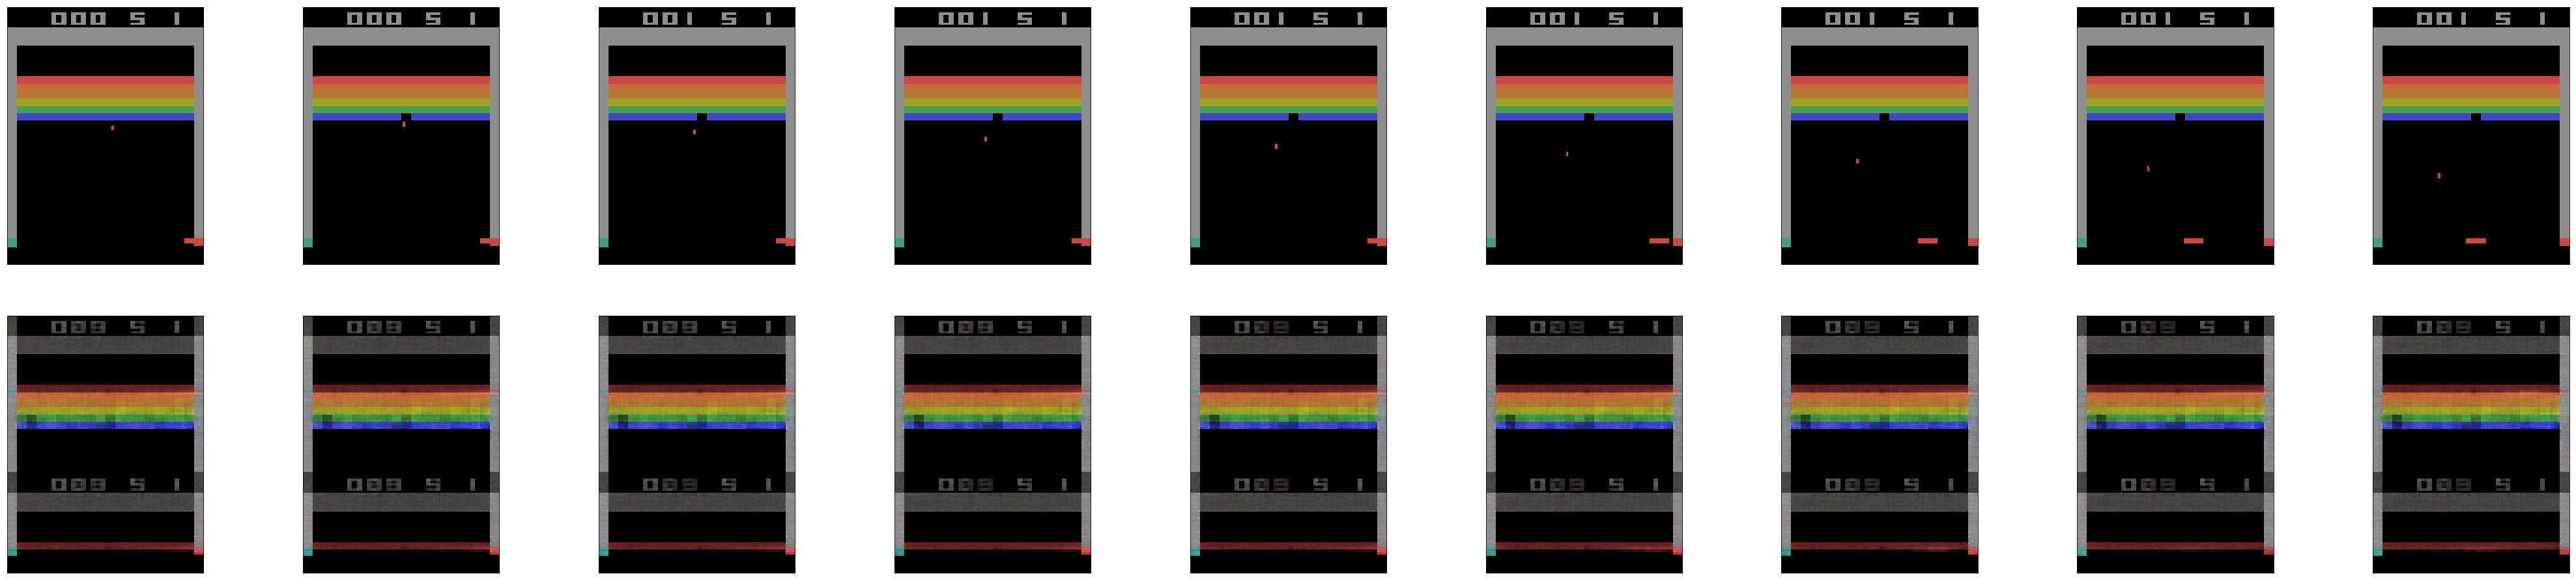

In [11]:
predict_start_state = 25
decoded_imgs = autopredictor.predict([first_frame_x[predict_start_state:predict_start_state+10], 
                                      second_frame_x[predict_start_state:predict_start_state+10]])
print(decoded_imgs.shape)
n = 10
plt.figure(figsize=(80, 16))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(second_frame_x[predict_start_state:predict_start_state+10][i].reshape(210, 160, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(210, 160, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## CombineFirst -> Shared

In [14]:
input_image = Input(shape=IMAGE_SHAPE)  # adapt this if using `channels_first` image data format

padding_x = int((256 - IMAGE_SHAPE[0]) / 2)
padding_y = int((256 - IMAGE_SHAPE[1]) / 2)

input_1 = Input(shape=IMAGE_SHAPE)
padded_input_1 = layers.ZeroPadding2D(padding=(padding_x, padding_y))(input_1)

input_2 = Input(shape=IMAGE_SHAPE)
padded_input_2 = layers.ZeroPadding2D(padding=(padding_x, padding_y))(input_2)

combined_input = layers.concatenate([padded_input_1, padded_input_2])

x = layers.Conv2D(64, (5, 5), activation='elu', padding='same')(combined_input)
x = layers.MaxPooling2D((4, 4), padding='same')(x)

x = layers.Conv2D(64, (4, 4), activation='elu', padding='same')(x)
x = layers.MaxPooling2D((4, 4), padding='same')(x)

x = layers.Conv2D(8, (3, 3), activation='elu', padding='same')(x)
x = layers.MaxPooling2D((4, 4), padding='same')(x)

bottle_neck = layers.Flatten(name="bottlneck_one")(x)

#####################################################################

x = layers.Reshape((4, 4, 8))(bottle_neck)

x = layers.UpSampling2D((4, 4))(x)
x = layers.Conv2D(64, (4, 4), activation='elu', padding='same')(x)

x = layers.UpSampling2D((4, 4))(x)
x = layers.Conv2D(64, (4, 4), activation='elu', padding='same')(x)

x = layers.UpSampling2D((4, 4))(x)
x = layers.Conv2D(3, (5, 5), activation='sigmoid', padding='same')(x)

decoded = layers.Cropping2D(cropping=(padding_x, padding_y))(x)

encoder = Model(inputs=[input_1, input_2], outputs=[bottle_neck])
autopredictor = Model([input_1, input_2], decoded)

autopredictor.compile(optimizer='Adam', loss='binary_crossentropy')
autopredictor.summary()

plot_model(autopredictor)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 210, 160, 3)  0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 210, 160, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 256, 256, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 256, 256, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
concatenat

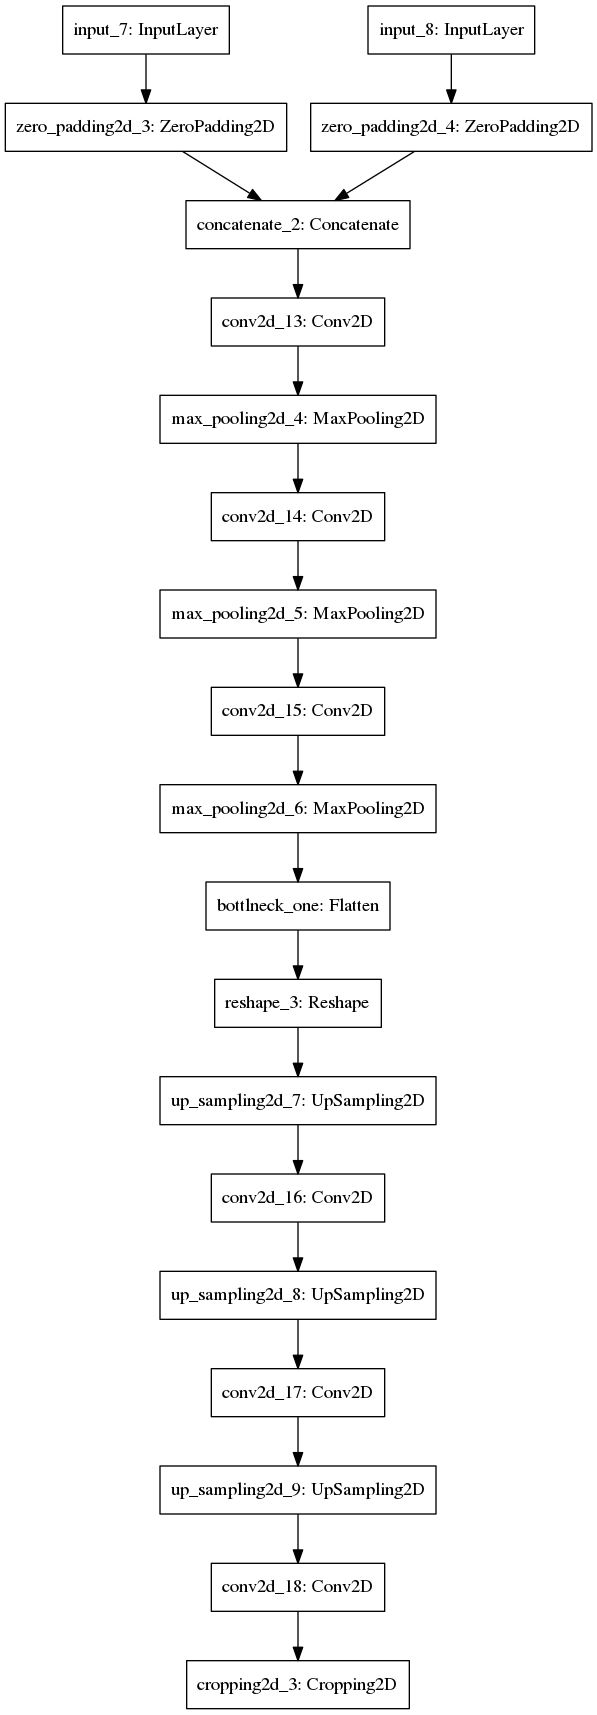

In [15]:
Image(retina=True, filename='model.png')

In [19]:
autopredictor.fit(x=[first_frame_x, second_frame_x],y=frame_y, epochs=10)

Epoch 1/10
9997/9997 [==============================] - 96s 10ms/step - loss: 7.1719
Epoch 2/10
9997/9997 [==============================] - 97s 10ms/step - loss: 6.2647
Epoch 3/10
9997/9997 [==============================] - 98s 10ms/step - loss: 6.1671
Epoch 4/10
9997/9997 [==============================] - 99s 10ms/step - loss: 6.1181
Epoch 5/10
9997/9997 [==============================] - 99s 10ms/step - loss: 6.0663
Epoch 6/10
9997/9997 [==============================] - 101s 10ms/step - loss: 6.0333
Epoch 7/10
9997/9997 [==============================] - 101s 10ms/step - loss: 5.9994
Epoch 8/10
9997/9997 [==============================] - 99s 10ms/step - loss: 5.9677
Epoch 9/10
9997/9997 [==============================] - 100s 10ms/step - loss: 5.9569
Epoch 10/10
9997/9997 [==============================] - 96s 10ms/step - loss: 5.9402


(10, 210, 160, 3)


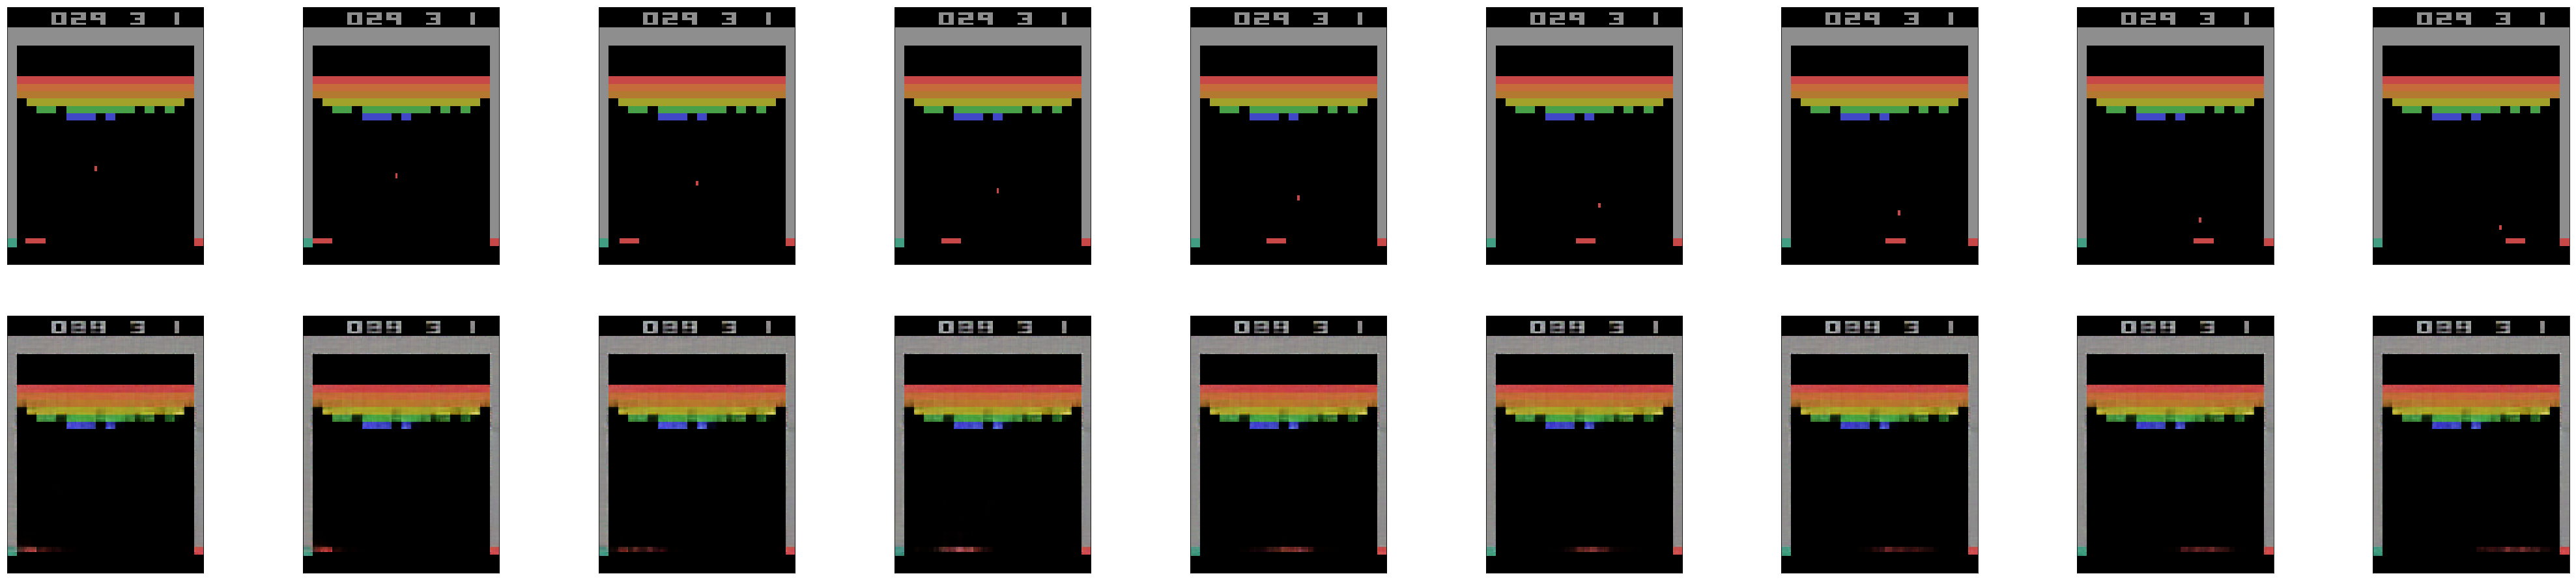

In [22]:
predict_start_state = 2346
decoded_imgs = autopredictor.predict([first_frame_x[predict_start_state:predict_start_state+10], 
                                      second_frame_x[predict_start_state:predict_start_state+10]])
print(decoded_imgs.shape)
n = 10
plt.figure(figsize=(80, 16))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(second_frame_x[predict_start_state:predict_start_state+10][i].reshape(210, 160, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(210, 160, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

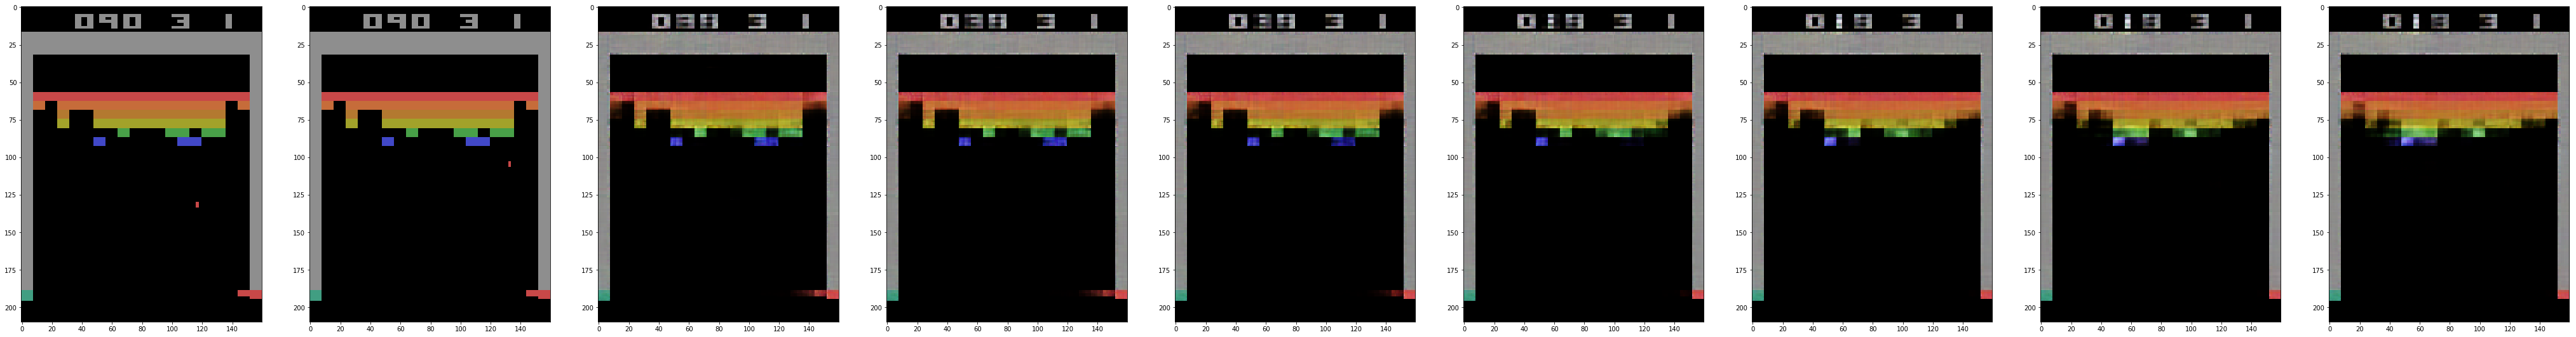

In [23]:
frame_1 = first_frame_x[1250]
frame_2 = second_frame_x[1250]

plt.figure(figsize=(80, 16))

ax = plt.subplot(1, 10, 1)
plt.imshow(frame_1)
ax = plt.subplot(1, 10, 2)
plt.imshow(frame_2)

for i in range(3, 10):
    prediction = autopredictor.predict([frame_1[None], frame_2[None]]).squeeze()
    ax = plt.subplot(1, 10, i)
    plt.imshow(prediction)
    frame_1, frame_2 = frame_2, prediction
    

In [ ]:
encoder.summary()
encoder.save('Models/Breakout/breakout_pixab2c.h5')

## AB-> Subtraction

In [16]:
input_image = Input(shape=IMAGE_SHAPE)  # adapt this if using `channels_first` image data format

padding_x = int((256 - IMAGE_SHAPE[0]) / 2)
padding_y = int((256 - IMAGE_SHAPE[1]) / 2)

input_1 = Input(shape=IMAGE_SHAPE)
padded_input_1 = layers.ZeroPadding2D(padding=(padding_x, padding_y))(input_1)

input_2 = Input(shape=IMAGE_SHAPE)
padded_input_2 = layers.ZeroPadding2D(padding=(padding_x, padding_y))(input_2)

delta = layers.subtract([padded_input_2, padded_input_1])

combined_input = layers.concatenate([padded_input_1, delta])

x = layers.Conv2D(64, (5, 5), activation='relu', padding='same')(combined_input)
x = layers.MaxPooling2D((4, 4), padding='same')(x)

x = layers.Conv2D(64, (4, 4), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((4, 4), padding='same')(x)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((4, 4), padding='same')(x)

bottle_neck = layers.Flatten(name="bottlneck_one")(x)

#####################################################################

x = layers.Reshape((4, 4, 8))(bottle_neck)

x = layers.UpSampling2D((4, 4))(x)
x = layers.Conv2D(64, (4, 4), activation='relu', padding='same')(x)

x = layers.UpSampling2D((4, 4))(x)
x = layers.Conv2D(64, (4, 4), activation='relu', padding='same')(x)

x = layers.UpSampling2D((4, 4))(x)
x = layers.Conv2D(3, (5, 5), activation='sigmoid', padding='same')(x)

decoded = layers.Cropping2D(cropping=(padding_x, padding_y))(x)

encoder = Model(inputs=[input_1, input_2], outputs=[bottle_neck])
autopredictor = Model([input_1, input_2], decoded)

autopredictor.compile(optimizer='Adam', loss='binary_crossentropy')
autopredictor.summary()

plot_model(autopredictor)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 210, 160, 3)  0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 210, 160, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 256, 256, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 256, 256, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
subtract_1

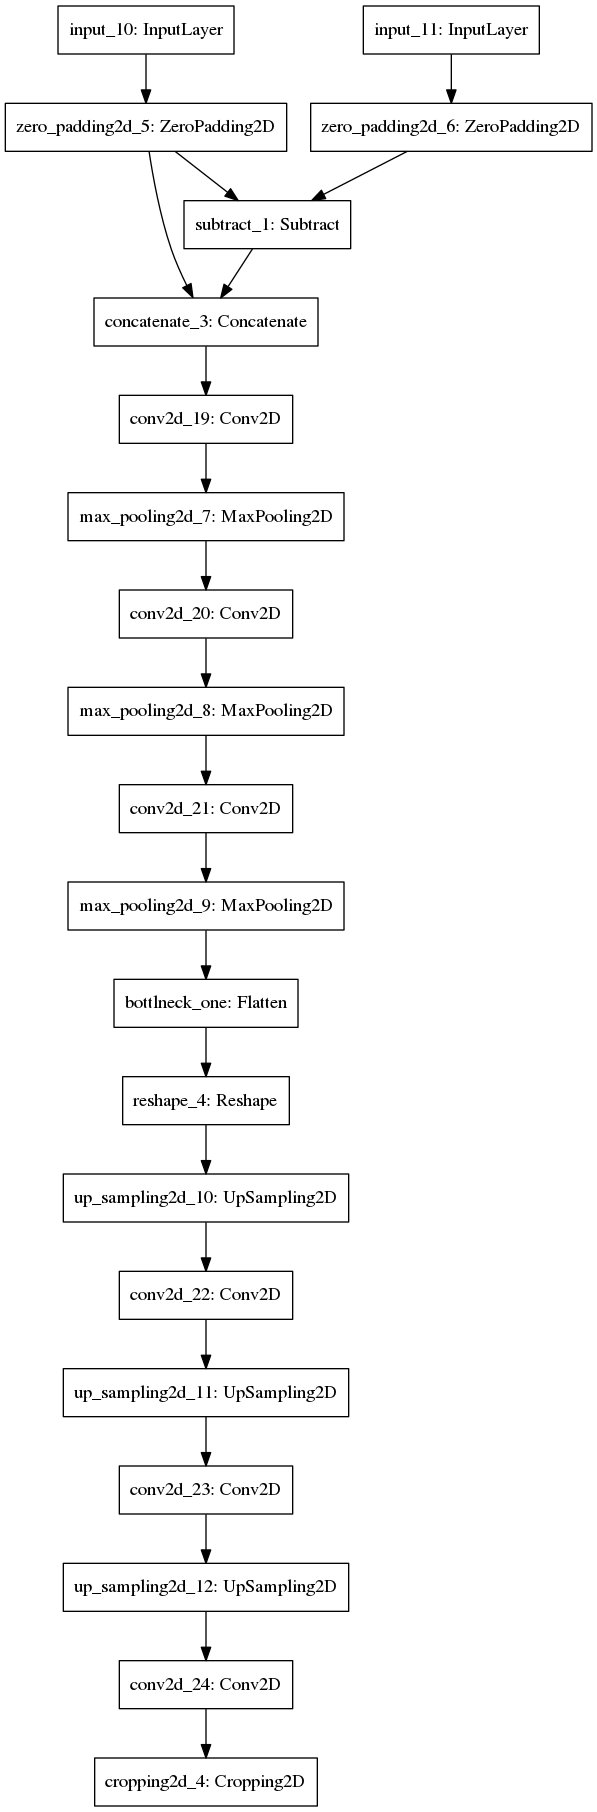

In [17]:
Image(retina=True, filename='model.png')

In [11]:
autopredictor.fit(x=[first_frame_x, second_frame_x],y=frame_y, epochs=5) 

Epoch 1/5
9997/9997 [==============================] - 95s 9ms/step - loss: 7.3306
Epoch 2/5
9997/9997 [==============================] - 87s 9ms/step - loss: 6.1941
Epoch 3/5
9997/9997 [==============================] - 85s 8ms/step - loss: 6.1130
Epoch 4/5
9997/9997 [==============================] - 84s 8ms/step - loss: 6.0533
Epoch 5/5
9997/9997 [==============================] - 88s 9ms/step - loss: 6.0186


(10, 210, 160, 3)


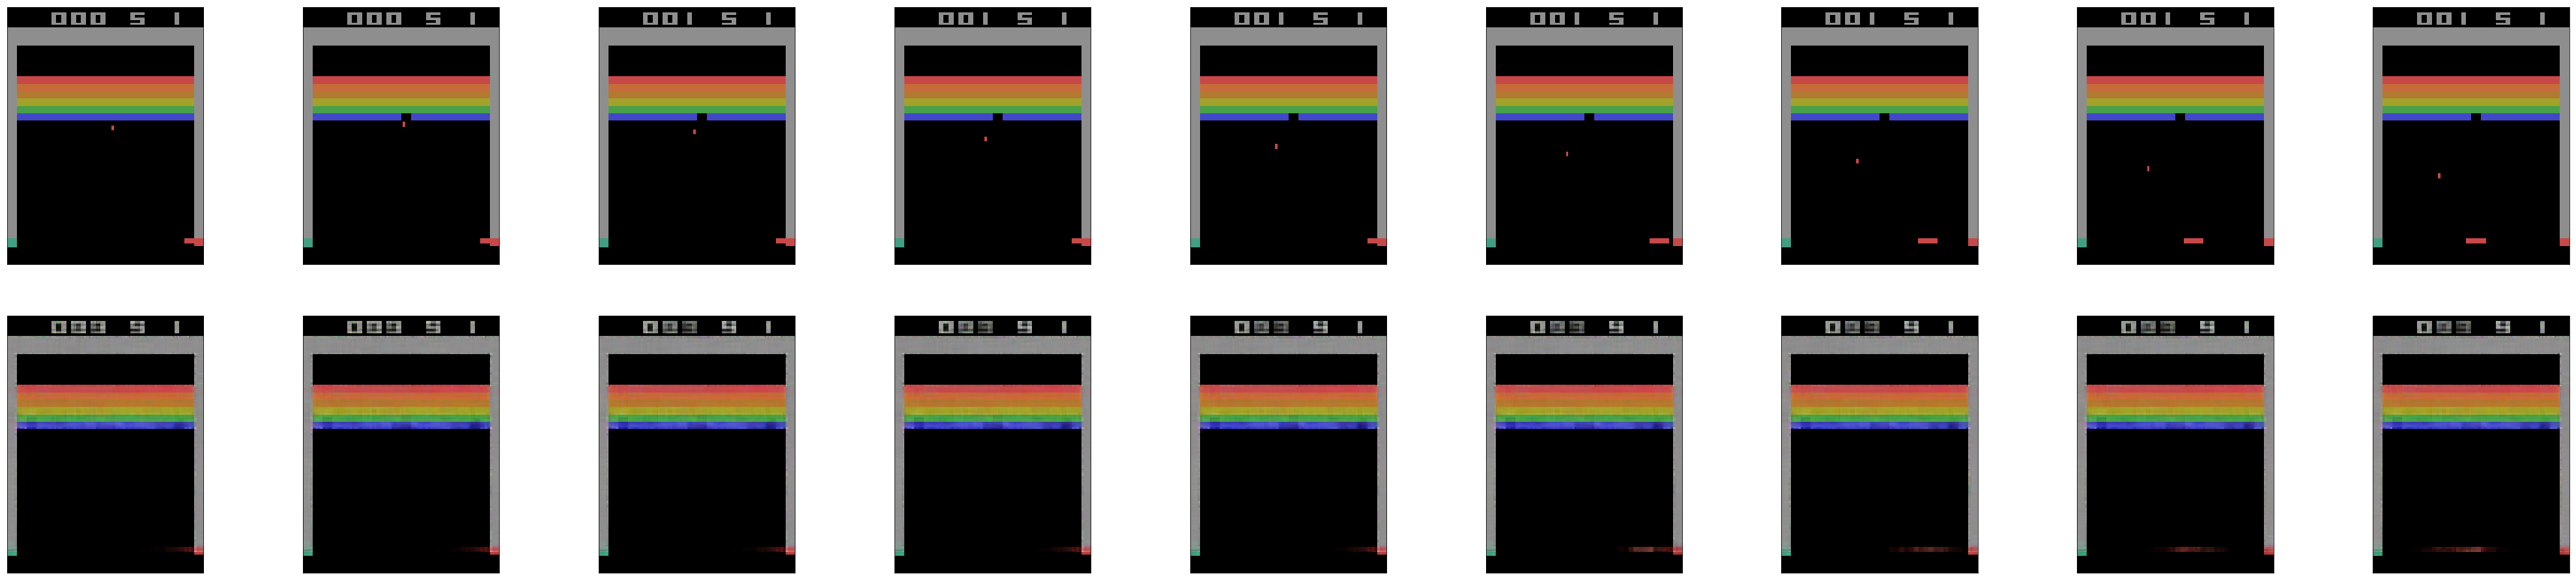

In [13]:
predict_start_state = 25
decoded_imgs = autopredictor.predict([first_frame_x[predict_start_state:predict_start_state+10], 
                                      second_frame_x[predict_start_state:predict_start_state+10]])
print(decoded_imgs.shape)
n = 10
plt.figure(figsize=(80, 16))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(second_frame_x[predict_start_state:predict_start_state+10][i].reshape(210, 160, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(210, 160, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## AB-> C + Mem(A) / 128 Bottleneck

In [92]:
MEMORY_SIZE=128

input_image = Input(shape=IMAGE_SHAPE)  # adapt this if using `channels_first` image data format

padding_x = int((256 - IMAGE_SHAPE[0]) / 2)
padding_y = int((256 - IMAGE_SHAPE[1]) / 2)

input_1 = Input(shape=IMAGE_SHAPE)
padded_input_1 = layers.ZeroPadding2D(padding=(padding_x, padding_y))(input_1)

input_2 = Input(shape=IMAGE_SHAPE)
padded_input_2 = layers.ZeroPadding2D(padding=(padding_x, padding_y))(input_2)

delta = layers.subtract([padded_input_2, padded_input_1])

combined_input = layers.concatenate([padded_input_1, delta])

x = layers.Conv2D(64, (5, 5), activation='relu', padding='same')(combined_input)
x = layers.MaxPooling2D((4, 4), padding='same')(x)

x = layers.Conv2D(64, (4, 4), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((4, 4), padding='same')(x)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((4, 4), padding='same')(x)

bottle_neck = layers.Flatten(name="bottlneck_one")(x)

m = layers.Dense(32)(bottle_neck)

m = layers.Dense(32)(m)

memory_output = layers.Dense(MEMORY_SIZE, name="mem")(m)


#####################################################################

x = layers.Reshape((4, 4, 8))(bottle_neck)

x = layers.UpSampling2D((4, 4))(x)
x = layers.Conv2D(64, (4, 4), activation='relu', padding='same')(x)

x = layers.UpSampling2D((4, 4))(x)
x = layers.Conv2D(64, (4, 4), activation='relu', padding='same')(x)

x = layers.UpSampling2D((4, 4))(x)
x = layers.Conv2D(3, (5, 5), activation='sigmoid', padding='same')(x)

decoded = layers.Cropping2D(cropping=(padding_x, padding_y), name="img")(x)

encoder = Model(inputs=[input_1, input_2], outputs=[bottle_neck])
image_decoder = Model([input_1, input_2], outputs=[decoded])
memory_decoder = Model([input_1, input_2], outputs=[memory_output])
autopredictor = Model([input_1, input_2], outputs=[decoded, memory_output])


autopredictor.compile(optimizer='Adam', loss='binary_crossentropy')
autopredictor.summary()

plot_model(autopredictor)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, 210, 160, 3)  0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           (None, 210, 160, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_20 (ZeroPadding2 (None, 256, 256, 3)  0           input_29[0][0]                   
__________________________________________________________________________________________________
zero_padding2d_21 (ZeroPadding2 (None, 256, 256, 3)  0           input_30[0][0]                   
__________________________________________________________________________________________________
subtract_9

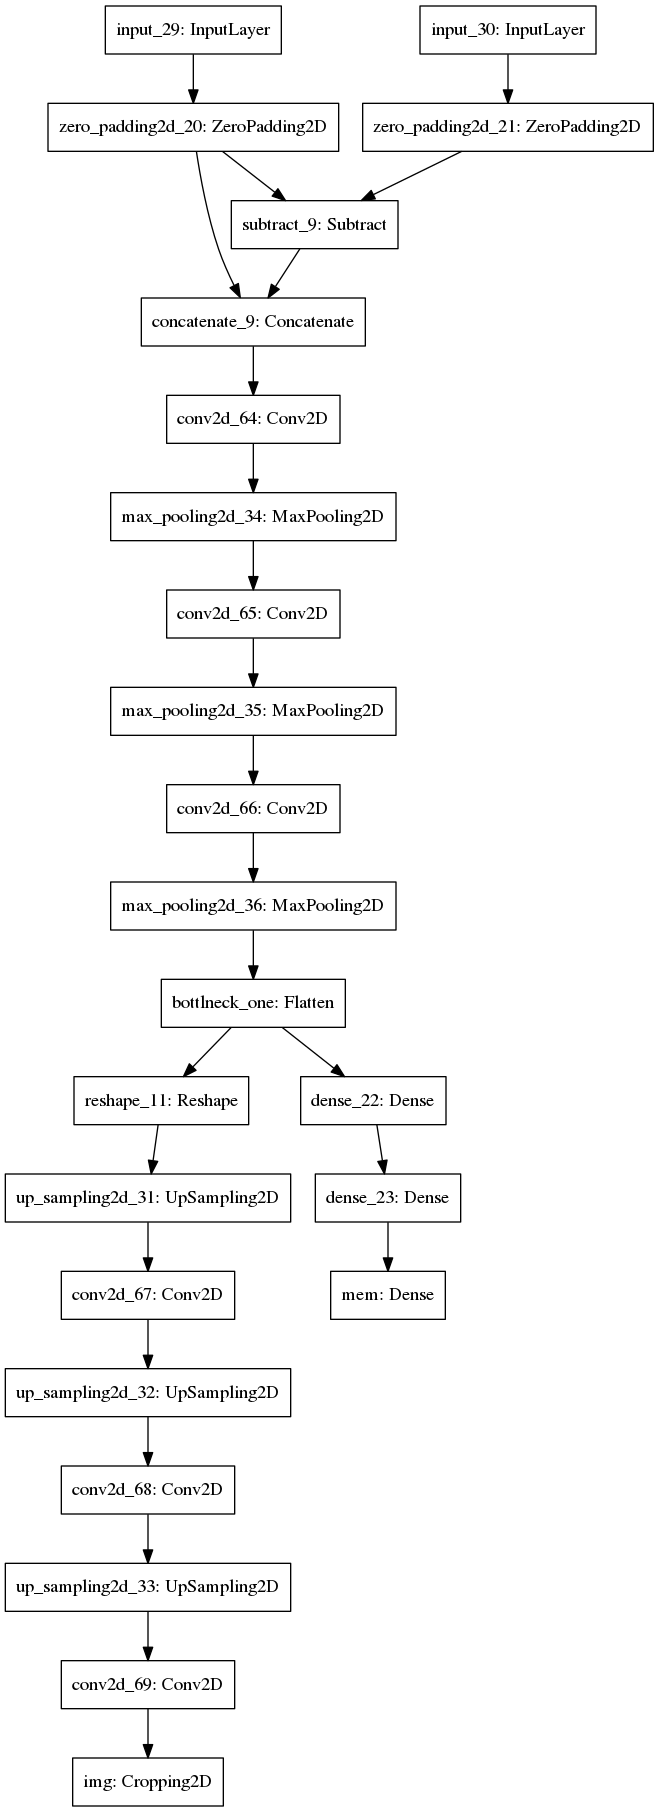

In [93]:
Image(retina=True, filename='model.png')

In [94]:
autopredictor.fit(x=[first_frame_x, second_frame_x],y=[frame_y,first_frame_memory], epochs=5) 

Epoch 1/5
2497/2497 [==============================] - 23s 9ms/step - loss: 2.8715 - img_loss: 0.3504 - mem_loss: 2.5212
Epoch 2/5
2497/2497 [==============================] - 22s 9ms/step - loss: 2.3754 - img_loss: 0.2277 - mem_loss: 2.1476
Epoch 3/5
2497/2497 [==============================] - 22s 9ms/step - loss: 2.3585 - img_loss: 0.2127 - mem_loss: 2.1458
Epoch 4/5
2497/2497 [==============================] - 23s 9ms/step - loss: 2.3510 - img_loss: 0.2063 - mem_loss: 2.1447
Epoch 5/5
2497/2497 [==============================] - 22s 9ms/step - loss: 2.3441 - img_loss: 0.2023 - mem_loss: 2.1417


(10, 210, 160, 3)
(10, 210, 160, 3)


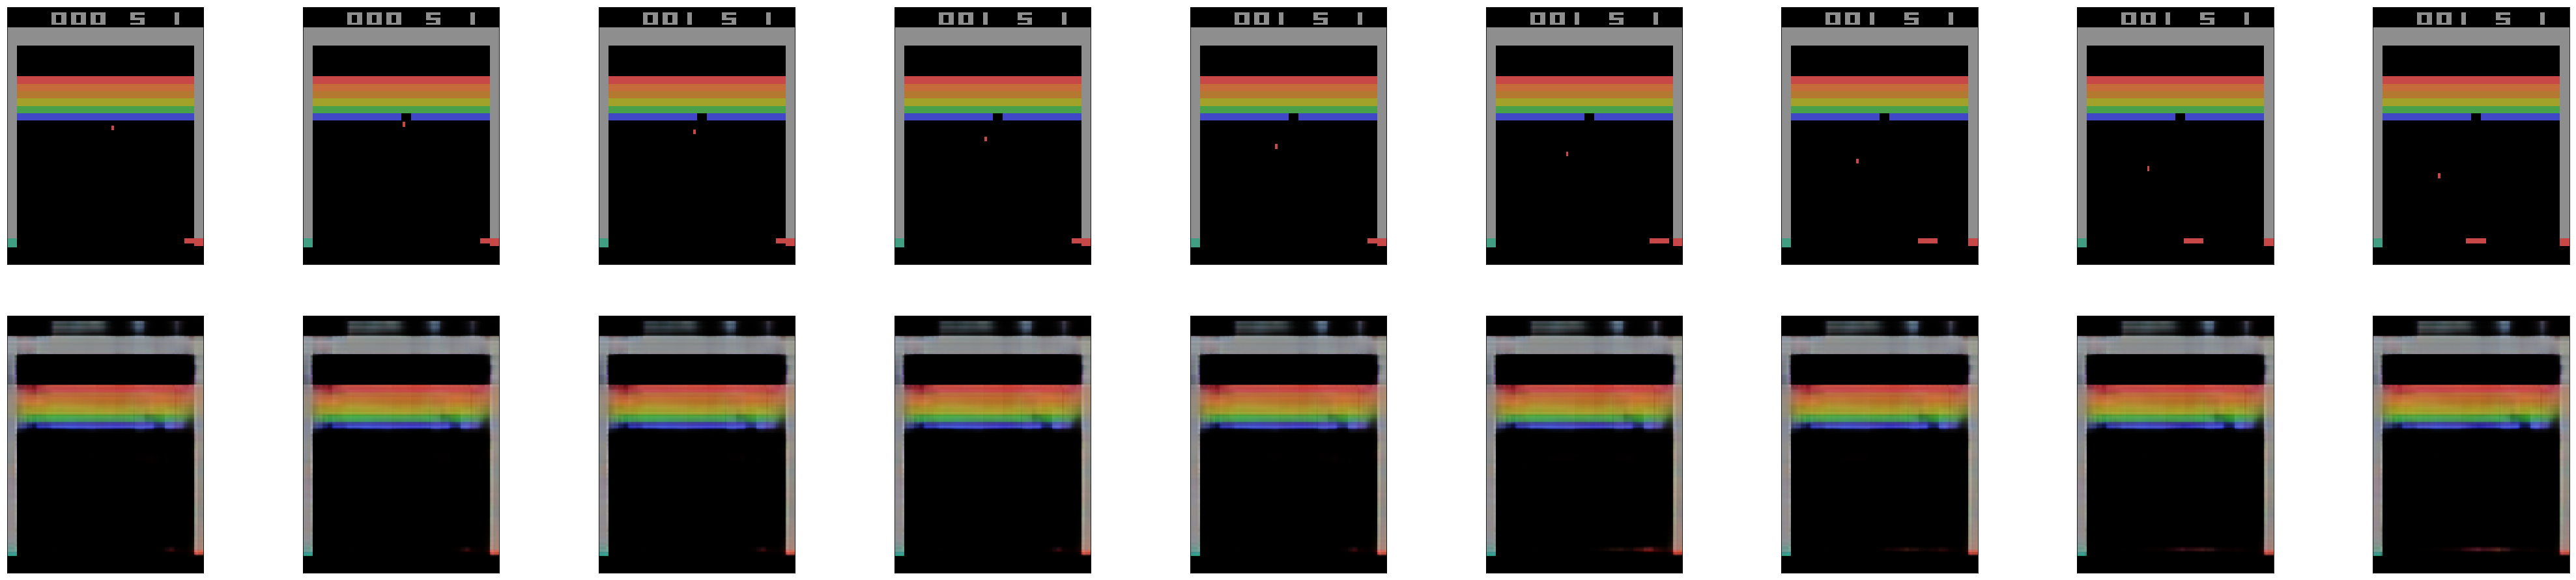

In [95]:
predict_start_state = 25
decoded_imgs = image_decoder.predict([first_frame_x[predict_start_state:predict_start_state+10], 
                                      second_frame_x[predict_start_state:predict_start_state+10]])
print(np.array(decoded_imgs).shape)
print(decoded_imgs.shape)
n = 10
plt.figure(figsize=(80, 16))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(second_frame_x[predict_start_state:predict_start_state+10][i].reshape(210, 160, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(210, 160, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## AB-> C + Mem(A) / BIG Bottleneck 2048

In [12]:
MEMORY_SIZE=128

input_image = Input(shape=IMAGE_SHAPE)  # adapt this if using `channels_first` image data format

padding_x = int((256 - IMAGE_SHAPE[0]) / 2)
padding_y = int((256 - IMAGE_SHAPE[1]) / 2)

input_1 = Input(shape=IMAGE_SHAPE)
padded_input_1 = layers.ZeroPadding2D(padding=(padding_x, padding_y))(input_1)

input_2 = Input(shape=IMAGE_SHAPE)
padded_input_2 = layers.ZeroPadding2D(padding=(padding_x, padding_y))(input_2)

delta = layers.subtract([padded_input_2, padded_input_1])

combined_input = layers.concatenate([padded_input_1, delta])

x = layers.Conv2D(64, (5, 5), activation='relu', padding='same')(combined_input)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(64, (4, 4), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((4, 4), padding='same')(x)

bottle_neck = layers.Flatten(name="bottlneck")(x)

####################################################################
m = layers.Dense(32, activation='relu')(bottle_neck)
m = layers.Dense(32, activation='relu')(m)
memory_output = layers.Dense(MEMORY_SIZE, activation='sigmoid', name="mem")(m)
####################################################################

x = layers.Reshape((16, 16, 8))(bottle_neck)

x = layers.UpSampling2D((4, 4))(x)
x = layers.Conv2D(64, (4, 4), activation='relu', padding='same')(x)

x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (4, 4), activation='relu', padding='same')(x)

x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(3, (5, 5), activation='sigmoid', padding='same')(x)

decoded = layers.Cropping2D(cropping=(padding_x, padding_y), name="img")(x)

encoder = Model(inputs=[input_1, input_2], outputs=[bottle_neck])
image_decoder = Model([input_1, input_2], outputs=[decoded])
memory_decoder = Model([input_1, input_2], outputs=[memory_output])
autopredictor = Model([input_1, input_2], outputs=[decoded, memory_output])


autopredictor.compile(optimizer='Adam', loss='binary_crossentropy')
autopredictor.summary()

# plot_model(autopredictor)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 210, 160, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 210, 160, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 256, 256, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
subtract_1

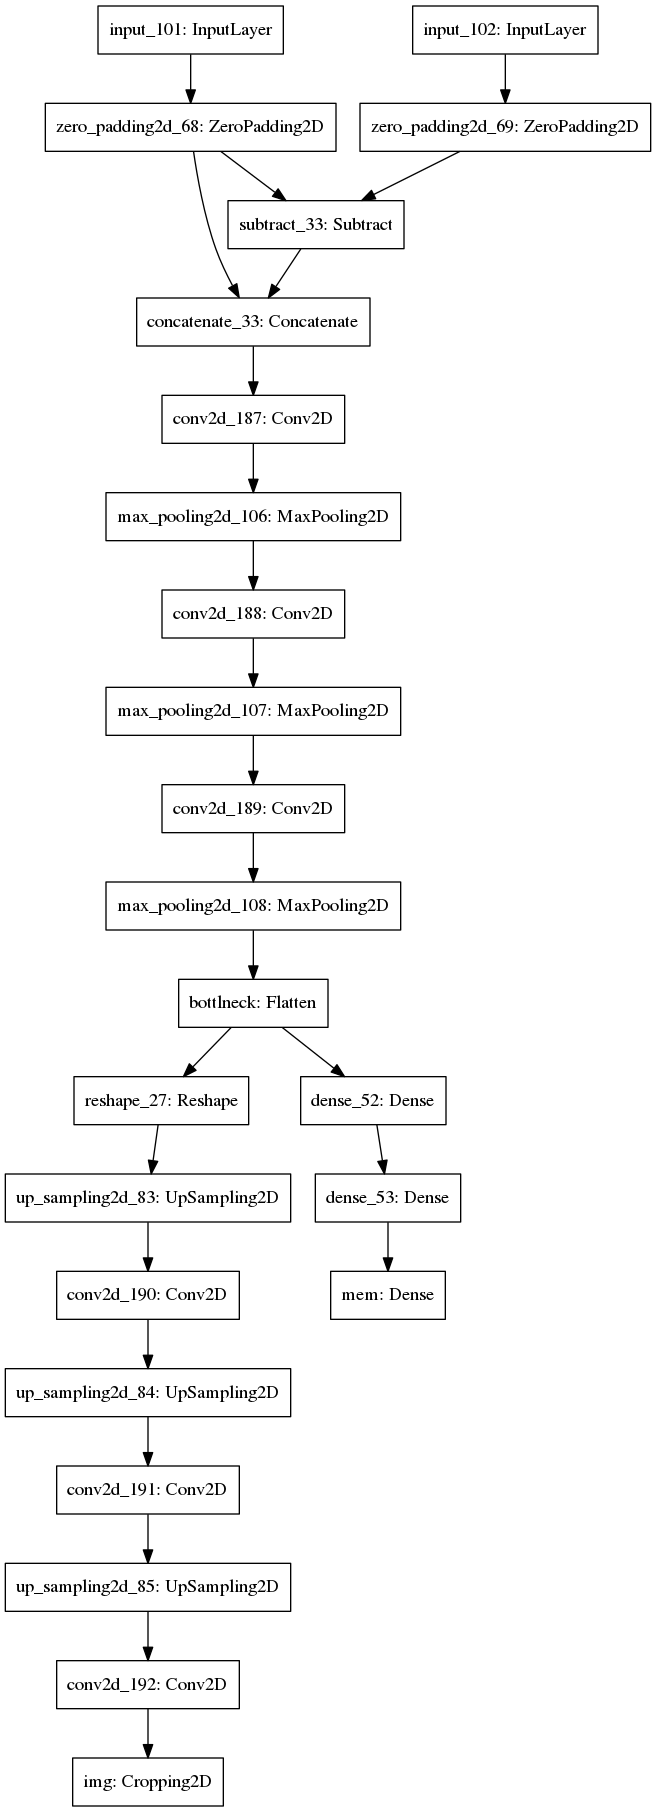

In [13]:
Image(retina=True, filename='model.png')

In [14]:
autopredictor.fit(x=[first_frame_x, second_frame_x],y=[frame_y,first_frame_memory], epochs=5) 

Epoch 1/5
9897/9897 [==============================] - 126s 13ms/step - loss: 0.5143 - img_loss: 0.2215 - mem_loss: 0.2928
Epoch 2/5
9897/9897 [==============================] - 115s 12ms/step - loss: 0.4193 - img_loss: 0.1899 - mem_loss: 0.2293
Epoch 3/5
9897/9897 [==============================] - 127s 13ms/step - loss: 0.4071 - img_loss: 0.1874 - mem_loss: 0.2197
Epoch 4/5
9897/9897 [==============================] - 127s 13ms/step - loss: 0.4017 - img_loss: 0.1857 - mem_loss: 0.2159
Epoch 5/5
9897/9897 [==============================] - 125s 13ms/step - loss: 0.3985 - img_loss: 0.1848 - mem_loss: 0.2137


(10, 210, 160, 3)
(10, 210, 160, 3)


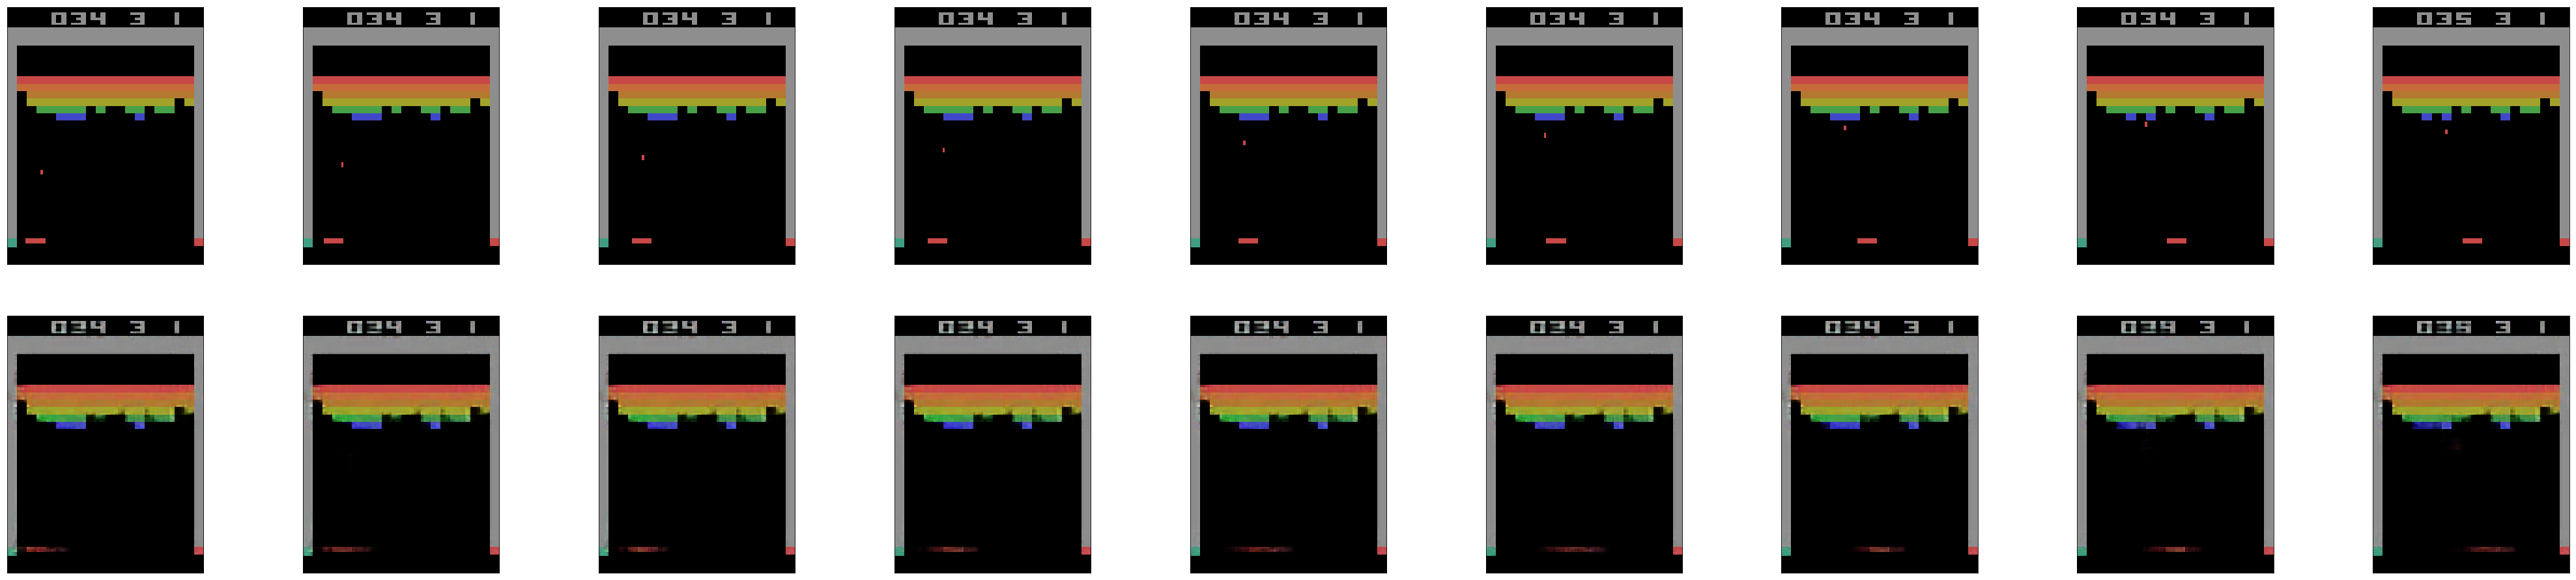

In [17]:
predict_start_state = 50
decoded_imgs = image_decoder.predict([x_test[predict_start_state:predict_start_state+10], 
                                      x_test[predict_start_state+1:predict_start_state+11]])
print(np.array(decoded_imgs).shape)
print(decoded_imgs.shape)
n = 10
plt.figure(figsize=(80, 16))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[predict_start_state:predict_start_state+10][i].reshape(210, 160, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(210, 160, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [18]:
encoder.save("brekout_pixab2cmem.h5")

In [19]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 210, 160, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 210, 160, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 256, 256, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
subtract_1

# A -> mem(A)

In [10]:
MEMORY_SIZE=128

input_img = Input(shape=IMAGE_SHAPE)  # adapt this if using `channels_first` image data format

padding_x = int((256 - IMAGE_SHAPE[0]) / 2)
padding_y = int((256 - IMAGE_SHAPE[1]) / 2)

padded_input = layers.ZeroPadding2D(padding=(padding_x, padding_y))(input_img)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(padded_input)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((4, 4), padding='same')(x)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((4, 4), padding='same')(x)

bottle_neck = layers.Flatten(name="bottlneck")(x)

x = layers.Dense(32, activation='relu')(bottle_neck)
x = layers.Dense(32, activation='relu')(x)

memory_output = layers.Dense(MEMORY_SIZE, activation='sigmoid', name="mem")(x)


encoder = Model(inputs=[input_img], outputs=[bottle_neck])
autopredictor = Model([input_img], outputs=[memory_output])


autopredictor.compile(optimizer='Adam', loss='binary_crossentropy')
autopredictor.summary()

plot_model(autopredictor)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 210, 160, 3)       0         
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 8)         4616      
__________

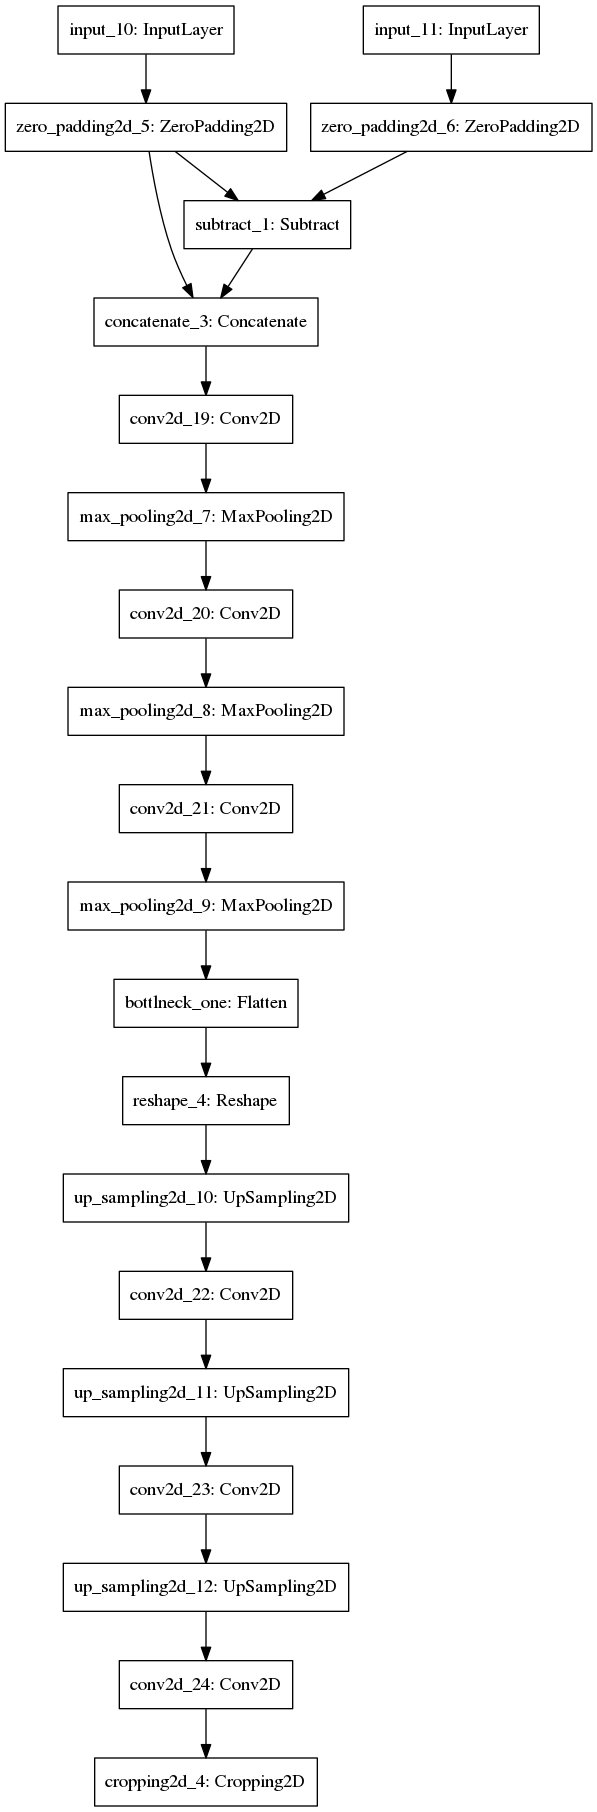

In [18]:
Image(retina=True, filename='model.png')

In [12]:
autopredictor.fit(x=x_train,y=x_mem_train, epochs=5) 

Epoch 1/5
9900/9900 [==============================] - 38s 4ms/step - loss: 0.2923
Epoch 2/5
9900/9900 [==============================] - 29s 3ms/step - loss: 0.2240
Epoch 3/5
9900/9900 [==============================] - 29s 3ms/step - loss: 0.2175
Epoch 4/5
9900/9900 [==============================] - 29s 3ms/step - loss: 0.2143
Epoch 5/5
9900/9900 [==============================] - 30s 3ms/step - loss: 0.2121


In [13]:
encoder.save("breakout_pix2mem.h5")

## Learn the Delta

The smallest value in delta frame: 0.0
The first frame shape: (2497, 210, 160, 3)
The second frame shape: (2497, 210, 160, 3)
The prediction frame shape: (2497, 210, 160, 3)
The memory has shape: (2497, 128)

The max of first_frame_x example 0.7843137254901961
The max of frame_y example 0.7843137254901961


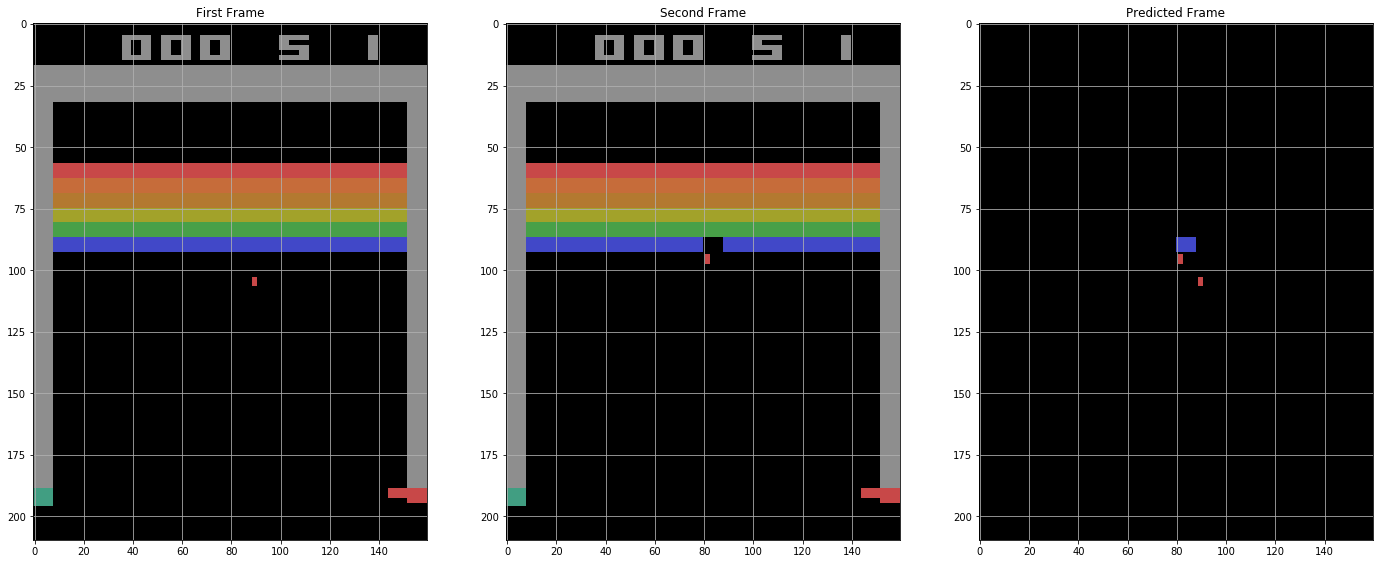

In [119]:
frame_to_show = 27
num_data_points = len(x_train)

frame_delta = 2
first_frame_x = x_train[0:num_data_points - frame_delta -1] 
second_frame_x = x_train[frame_delta: num_data_points - 1] 
# frame_y = x_train[(frame_delta + 1): num_data_points]
frame_y = np.abs(second_frame_x - first_frame_x)
print("The smallest value in delta frame:", np.min(frame_y))


first_frame_memory = x_mem_train[0:num_data_points - frame_delta -1] 
print("The first frame shape:", first_frame_x.shape)
print("The second frame shape:", second_frame_x.shape)
print("The prediction frame shape:", frame_y.shape)
print("The memory has shape:", first_frame_memory.shape)
print()
print("The max of first_frame_x example", np.max(first_frame_x[frame_to_show]))
print("The max of frame_y example", np.max(frame_y[frame_to_show]))

assert (first_frame_x.shape) == (second_frame_x.shape) == (frame_y.shape), "All the arrays should be the same shape!"

fig=plt.figure(figsize=(24, 12))
ax = plt.subplot(1, 3, 1)
plt.imshow(first_frame_x[frame_to_show])
plt.title("First Frame")
plt.grid()

ax = plt.subplot(1, 3, 2)
plt.title("Second Frame")
plt.imshow(second_frame_x[frame_to_show])
plt.grid()

ax = plt.subplot(1, 3, 3)
plt.title("Predicted Frame")
plt.imshow((frame_y[frame_to_show]))
plt.grid()


In [124]:
input_one = Input(shape=IMAGE_SHAPE)  # adapt this if using `channels_first` image data format
input_two = Input(shape=IMAGE_SHAPE)

padding_x = int((256 - IMAGE_SHAPE[0]) / 2)
padding_y = int((256 - IMAGE_SHAPE[1]) / 2)

x = layers.ZeroPadding2D(padding=(padding_x, padding_y))(input_one)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

input_one_encoding = layers.Flatten(name="bottlneck_one")(x)

######################################################################

x = layers.ZeroPadding2D(padding=(padding_x, padding_y))(input_two)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

input_two_encoding = layers.Flatten(name="bottlneck_two")(x)

#####################################################################

bottleneck_layer = layers.concatenate([input_one_encoding, input_two_encoding])
x = layers.Reshape((32, 32, 16))(bottleneck_layer)

x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

decoded = layers.Cropping2D(cropping=(padding_x, padding_y))(x)

encoder = Model(inputs=[input_one, input_two], outputs=[bottleneck_layer])
autopredictor = Model([input_one, input_two], decoded)

def binary_crossentropy(y_true, y_pred):
    return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

def max_binary_crossentropy(y_true, y_pred):
    return K.max(K.binary_crossentropy(y_true, y_pred), axis=-1)

autopredictor.compile(optimizer='Adam', loss=max_binary_crossentropy)
autopredictor.summary()

plot_model(autopredictor)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_68 (InputLayer)           (None, 210, 160, 3)  0                                            
__________________________________________________________________________________________________
input_69 (InputLayer)           (None, 210, 160, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_67 (ZeroPadding2 (None, 256, 256, 3)  0           input_68[0][0]                   
__________________________________________________________________________________________________
zero_padding2d_68 (ZeroPadding2 (None, 256, 256, 3)  0           input_69[0][0]                   
__________________________________________________________________________________________________
conv2d_262

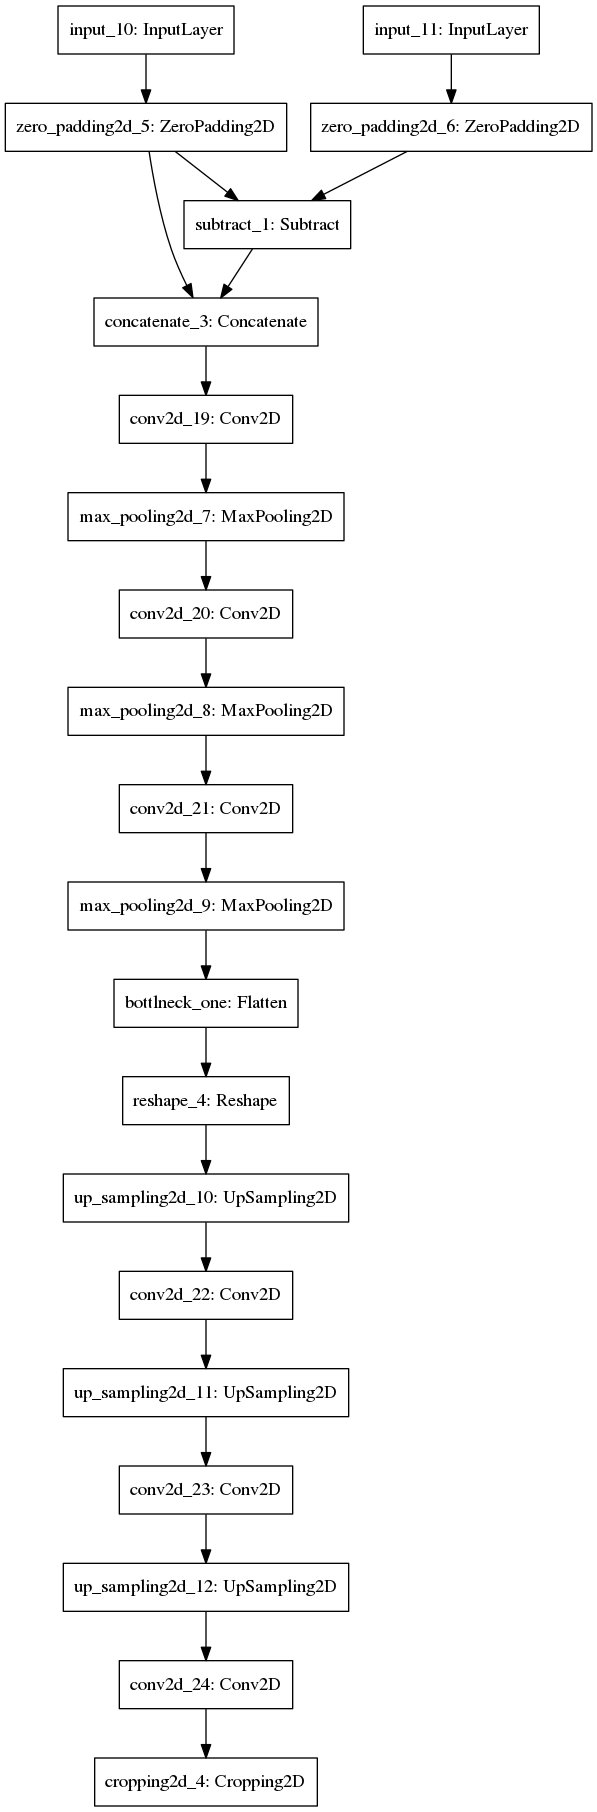

In [19]:
Image(retina=True, filename='model.png')

In [128]:
autopredictor.fit(x=[first_frame_x[0:1], second_frame_x[0:1]],y=[frame_y[0:1]], epochs=100) 

Epoch 1/100
1/1 [==============================] - 0s 22ms/step - loss: 834.6026
Epoch 2/100
1/1 [==============================] - 0s 18ms/step - loss: 834.6026
Epoch 3/100
1/1 [==============================] - 0s 16ms/step - loss: 834.6026
Epoch 4/100
1/1 [==============================] - 0s 17ms/step - loss: 834.6026
Epoch 5/100
1/1 [==============================] - 0s 16ms/step - loss: 834.6026
Epoch 6/100
1/1 [==============================] - 0s 17ms/step - loss: 834.6026
Epoch 7/100
1/1 [==============================] - 0s 18ms/step - loss: 834.6026
Epoch 8/100
1/1 [==============================] - 0s 20ms/step - loss: 834.6026
Epoch 9/100
1/1 [==============================] - 0s 23ms/step - loss: 834.6026
Epoch 10/100
1/1 [==============================] - 0s 23ms/step - loss: 834.6026
Epoch 11/100
1/1 [==============================] - 0s 22ms/step - loss: 834.6026
Epoch 12/100
1/1 [==============================] - 0s 21ms/step - loss: 834.6026
Epoch 13/100
1/1 [=======

Max value of the distance: 200
Max value of the prediction: 0.0


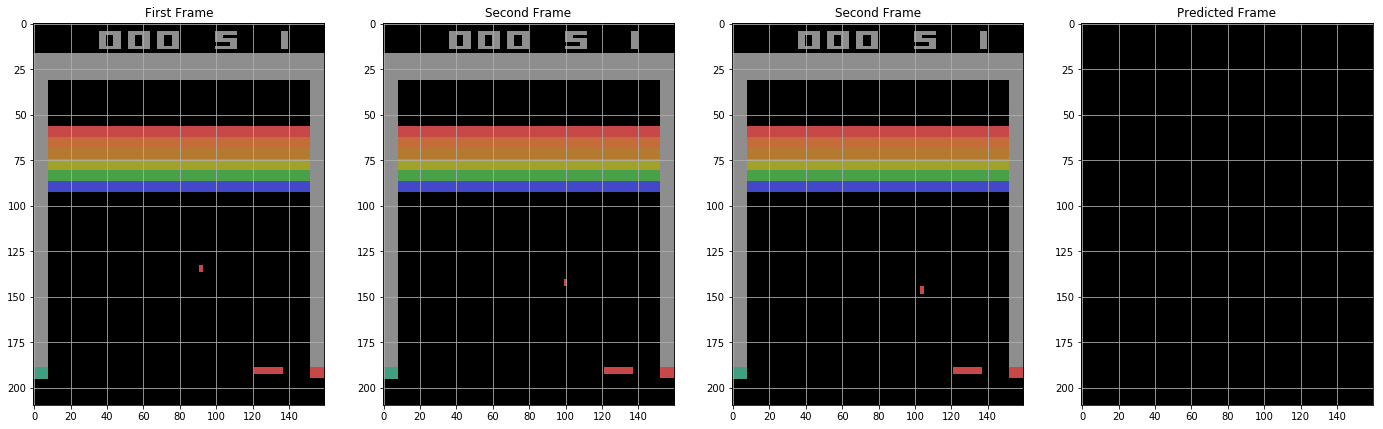

In [129]:
frame_to_show = 28
print("Max value of the distance:", np.max(frame_y[0:1]))
print("Max value of the prediction:", np.max(list(autopredictor.predict([[first_frame_x[frame_to_show]],[second_frame_x[frame_to_show]]]).squeeze())))

fig=plt.figure(figsize=(24, 12))
ax = plt.subplot(1, 4, 1)
plt.imshow(first_frame_x[0])
plt.title("First Frame")
plt.grid()

ax = plt.subplot(1, 4, 2)
plt.title("Second Frame")
plt.imshow(second_frame_x[0])
plt.grid()

ax = plt.subplot(1, 4, 3)
plt.title("Second Frame")
plt.imshow(frame_y[0])
plt.grid()

ax = plt.subplot(1, 4, 4)
plt.title("Predicted Frame")
plt.imshow((autopredictor.predict([first_frame_x[0:1],second_frame_x[0:1]]).squeeze()))
plt.grid()


## A+ B-A -> C + C-B

The smallest value in delta frame: 0.0
The first frame shape: (4998, 210, 160, 3)
The second frame shape: (4998, 210, 160, 3)
The prediction frame shape: (4998, 210, 160, 3)
The frame_delta_y has shape: (4998, 210, 160, 3)

The max of first_frame_x example 0.7843137254901961
The max of frame_y example 0.7843137254901961


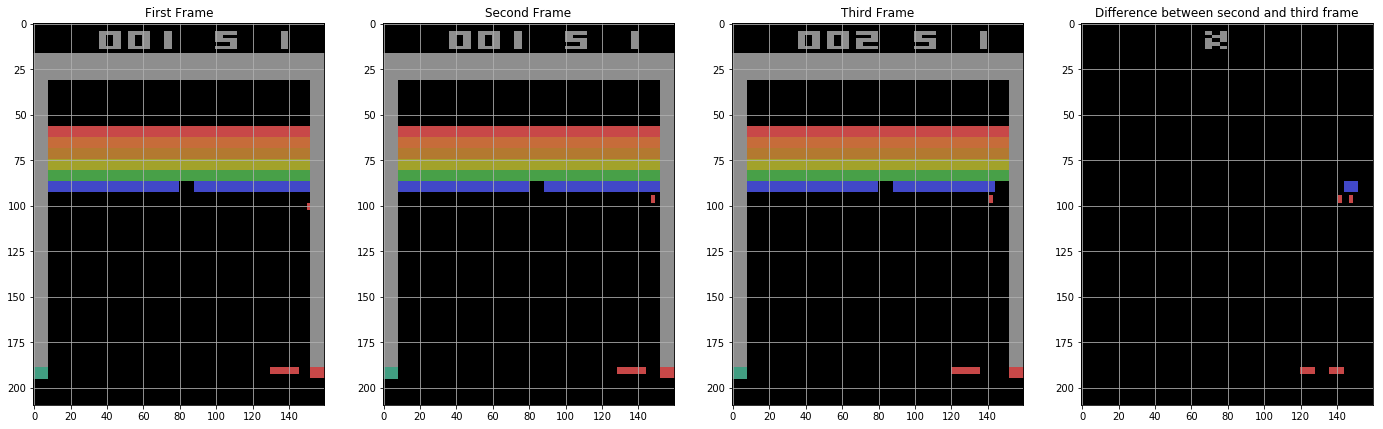

In [4]:
frame_to_show = 66
num_data_points = len(x_train)

del x_mem_train

frame_delta = 1
first_frame_x = x_train[0:num_data_points - frame_delta -1] 
second_frame_x = x_train[frame_delta: num_data_points - 1] 
frame_y = x_train[(frame_delta + 1): num_data_points]
del x_train
frame_delta_y = np.abs(second_frame_x - frame_y)
print("The smallest value in delta frame:", np.min(frame_y))


# first_frame_memory = x_mem_train[0:num_data_points - frame_delta -1] 
print("The first frame shape:", first_frame_x.shape)
print("The second frame shape:", second_frame_x.shape)
print("The prediction frame shape:", frame_y.shape)
print("The frame_delta_y has shape:", frame_delta_y.shape)
print()
print("The max of first_frame_x example", np.max(first_frame_x[frame_to_show]))
print("The max of frame_y example", np.max(frame_y[frame_to_show]))

assert (first_frame_x.shape) == (second_frame_x.shape) == (frame_y.shape) == (frame_delta_y.shape), "All the arrays should be the same shape!"

fig=plt.figure(figsize=(24, 12))
ax = plt.subplot(1, 4, 1)
plt.imshow(first_frame_x[frame_to_show])
plt.title("First Frame")
plt.grid()

ax = plt.subplot(1, 4, 2)
plt.title("Second Frame")
plt.imshow(second_frame_x[frame_to_show])
plt.grid()

ax = plt.subplot(1, 4, 3)
plt.title("Third Frame")
plt.imshow((frame_y[frame_to_show]))
plt.grid()

ax = plt.subplot(1, 4, 4)
plt.title("Difference between second and third frame")
plt.imshow((frame_delta_y[frame_to_show]))
plt.grid()

In [20]:
MEMORY_SIZE=128

input_image = Input(shape=IMAGE_SHAPE)  # adapt this if using `channels_first` image data format

padding_x = int((256 - IMAGE_SHAPE[0]) / 2)
padding_y = int((256 - IMAGE_SHAPE[1]) / 2)

input_1 = Input(shape=IMAGE_SHAPE)
padded_input_1 = layers.ZeroPadding2D(padding=(padding_x, padding_y))(input_1)

input_2 = Input(shape=IMAGE_SHAPE)
padded_input_2 = layers.ZeroPadding2D(padding=(padding_x, padding_y))(input_2)

delta = layers.subtract([padded_input_2, padded_input_1])

combined_input = layers.concatenate([padded_input_1, delta])

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(combined_input)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

bottle_neck = layers.Flatten(name="bottlneck_one")(x)

#####################################################################

reshaped = layers.Reshape((32, 32, 8))(bottle_neck)

#####################################################################

x = layers.UpSampling2D((2, 2))(reshaped)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

delta_decoded = layers.Cropping2D(cropping=(padding_x, padding_y), name="d_img")(x)

#####################################################################

x = layers.UpSampling2D((2, 2))(reshaped)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

decoded = layers.Cropping2D(cropping=(padding_x, padding_y), name="img")(x)

encoder = Model(inputs=[input_1, input_2], outputs=[bottle_neck])
image_decoder = Model([input_1, input_2], outputs=[decoded])
autopredictor = Model([input_1, input_2], outputs=[decoded, delta_decoded])


autopredictor.compile(optimizer='Adam', loss='binary_crossentropy')
autopredictor.summary()

plot_model(autopredictor)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 210, 160, 3)  0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 210, 160, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_7 (ZeroPadding2D (None, 256, 256, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
zero_padding2d_8 (ZeroPadding2D (None, 256, 256, 3)  0           input_14[0][0]                   
__________________________________________________________________________________________________
subtract_2

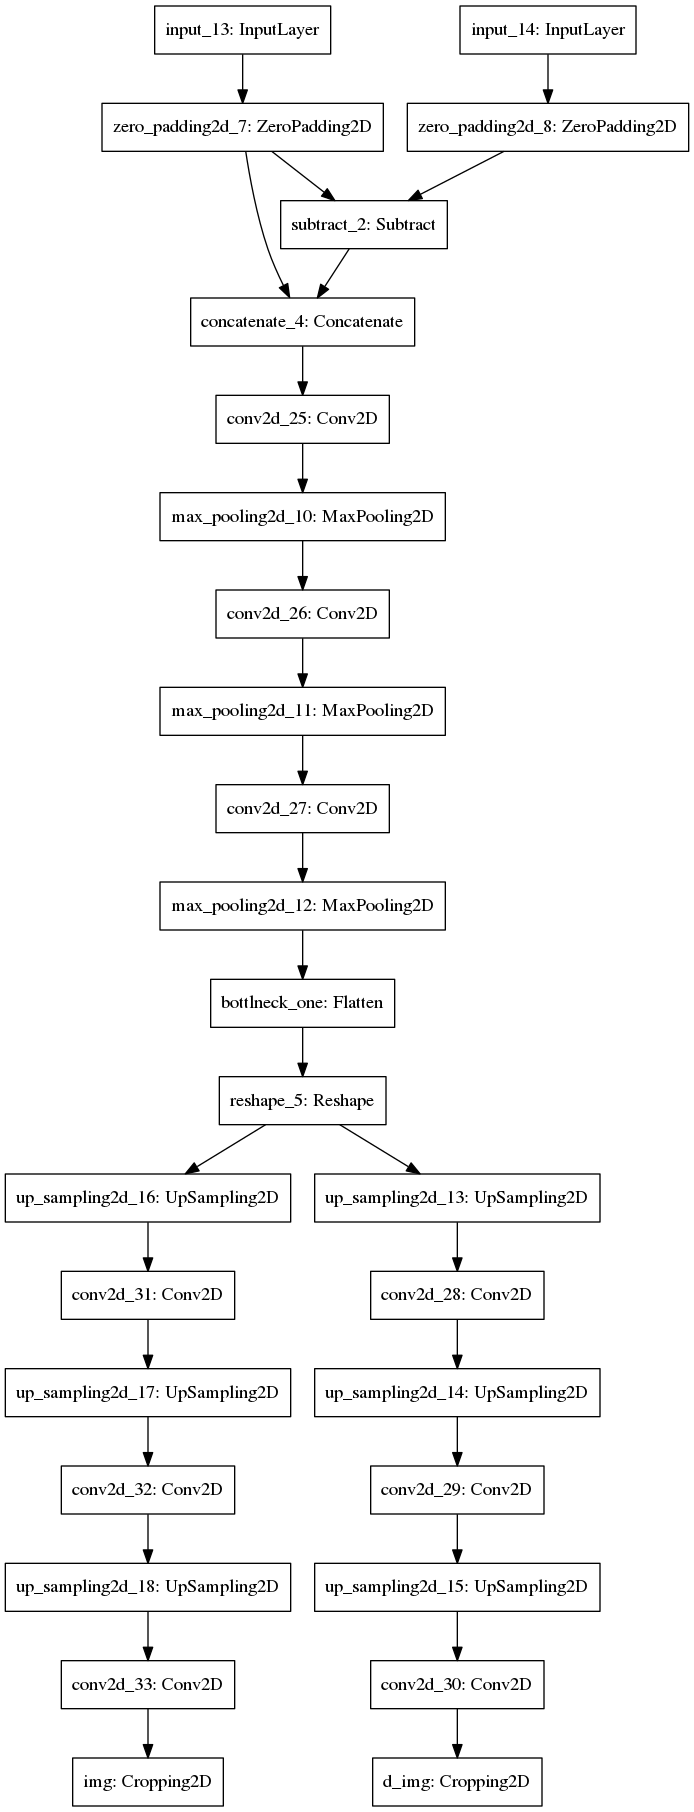

In [21]:
Image(retina=True, filename='model.png')

In [ ]:
autopredictor.fit(x=[first_frame_x, second_frame_x],y=[frame_y, frame_delta_y], epochs=5) 

Epoch 1/5
4998/4998 [==============================] - 75s 15ms/step - loss: 0.2975 - img_loss: 0.2464 - delta_img_loss: 0.0512
Epoch 2/5
4998/4998 [==============================] - 66s 13ms/step - loss: 0.2048 - img_loss: 0.1876 - delta_img_loss: 0.0172
Epoch 3/5
4998/4998 [==============================] - 68s 14ms/step - loss: 0.2020 - img_loss: 0.1848 - delta_img_loss: 0.0172
Epoch 4/5
4998/4998 [==============================] - 71s 14ms/step - loss: 0.2007 - img_loss: 0.1835 - delta_img_loss: 0.0172
Epoch 5/5
4096/4998 [=======================>......] - ETA: 12s - loss: 0.2000 - img_loss: 0.1828 - delta_img_loss: 0.0172

In [ ]:
encoder.save("")
encoder.summary()

The smallest value in delta frame: 0.0
The first frame shape: (997, 210, 160, 3)
The second frame shape: (997, 210, 160, 3)
The prediction frame shape: (997, 210, 160, 3)
The memory has shape: (997, 128)

The max of first_frame_x example 0.7843137254901961
The max of frame_y example 0.7843137254901961


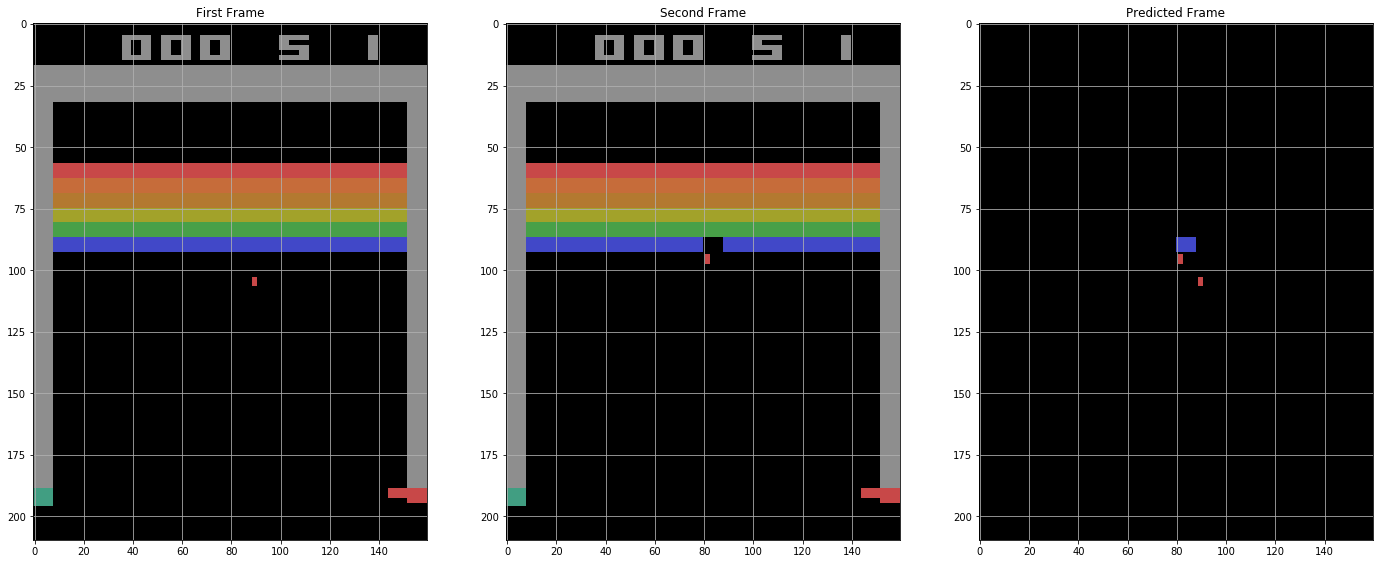

In [4]:
frame_to_show = 27
num_data_points = len(x_train)

frame_delta = 2
first_frame_x = x_train[0:num_data_points - frame_delta -1] 
second_frame_x = x_train[frame_delta: num_data_points - 1] 
# frame_y = x_train[(frame_delta + 1): num_data_points]
frame_y = np.abs(second_frame_x - first_frame_x)
print("The smallest value in delta frame:", np.min(frame_y))


first_frame_memory = x_mem_train[0:num_data_points - frame_delta -1] 
print("The first frame shape:", first_frame_x.shape)
print("The second frame shape:", second_frame_x.shape)
print("The prediction frame shape:", frame_y.shape)
print("The memory has shape:", first_frame_memory.shape)
print()
print("The max of first_frame_x example", np.max(first_frame_x[frame_to_show]))
print("The max of frame_y example", np.max(frame_y[frame_to_show]))

assert (first_frame_x.shape) == (second_frame_x.shape) == (frame_y.shape), "All the arrays should be the same shape!"

fig=plt.figure(figsize=(24, 12))
ax = plt.subplot(1, 3, 1)
plt.imshow(first_frame_x[frame_to_show])
plt.title("First Frame")
plt.grid()

ax = plt.subplot(1, 3, 2)
plt.title("Second Frame")
plt.imshow(second_frame_x[frame_to_show])
plt.grid()

ax = plt.subplot(1, 3, 3)
plt.title("Predicted Frame")
plt.imshow((frame_y[frame_to_show]))
plt.grid()


In [36]:
input_image = Input(shape=IMAGE_SHAPE)  # adapt this if using `channels_first` image data format

padding_x = int((256 - IMAGE_SHAPE[0]) / 2)
padding_y = int((256 - IMAGE_SHAPE[1]) / 2)

input_1 = Input(shape=IMAGE_SHAPE)
padded_input_1 = layers.ZeroPadding2D(padding=(padding_x, padding_y))(input_1)

input_2 = Input(shape=IMAGE_SHAPE)
padded_input_2 = layers.ZeroPadding2D(padding=(padding_x, padding_y))(input_2)

combined_input = layers.concatenate([padded_input_1, padded_input_2], axis=3)

x = layers.Conv2D(64, (5, 5), activation='relu', padding='same')(combined_input)
x = layers.MaxPooling2D((4, 4), padding='same')(x)

x = layers.Conv2D(64, (4, 4), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((4, 4), padding='same')(x)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((4, 4), padding='same')(x)

bottle_neck = layers.Flatten(name="bottlneck_one")(x)

#####################################################################

x = layers.Reshape((4, 4, 8))(bottle_neck)

x = layers.UpSampling2D((4, 4))(x)
x = layers.Conv2D(64, (4, 4), activation='relu', padding='same')(x)

x = layers.UpSampling2D((4, 4))(x)
x = layers.Conv2D(64, (4, 4), activation='relu', padding='same')(x)

x = layers.UpSampling2D((4, 4))(x)
x = layers.Conv2D(3, (5, 5), activation='sigmoid', padding='same')(x)

decoded = layers.Cropping2D(cropping=(padding_x, padding_y))(x)

encoder = Model(inputs=[input_1, input_2], outputs=[bottle_neck])
autopredictor = Model([input_1, input_2], decoded)

autopredictor.compile(optimizer='Adam', loss='binary_crossentropy')
autopredictor.summary()

plot_model(autopredictor)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_50 (InputLayer)           (None, 210, 160, 3)  0                                            
__________________________________________________________________________________________________
input_51 (InputLayer)           (None, 210, 160, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_33 (ZeroPadding2 (None, 256, 256, 3)  0           input_50[0][0]                   
__________________________________________________________________________________________________
zero_padding2d_34 (ZeroPadding2 (None, 256, 256, 3)  0           input_51[0][0]                   
__________________________________________________________________________________________________
concatenat

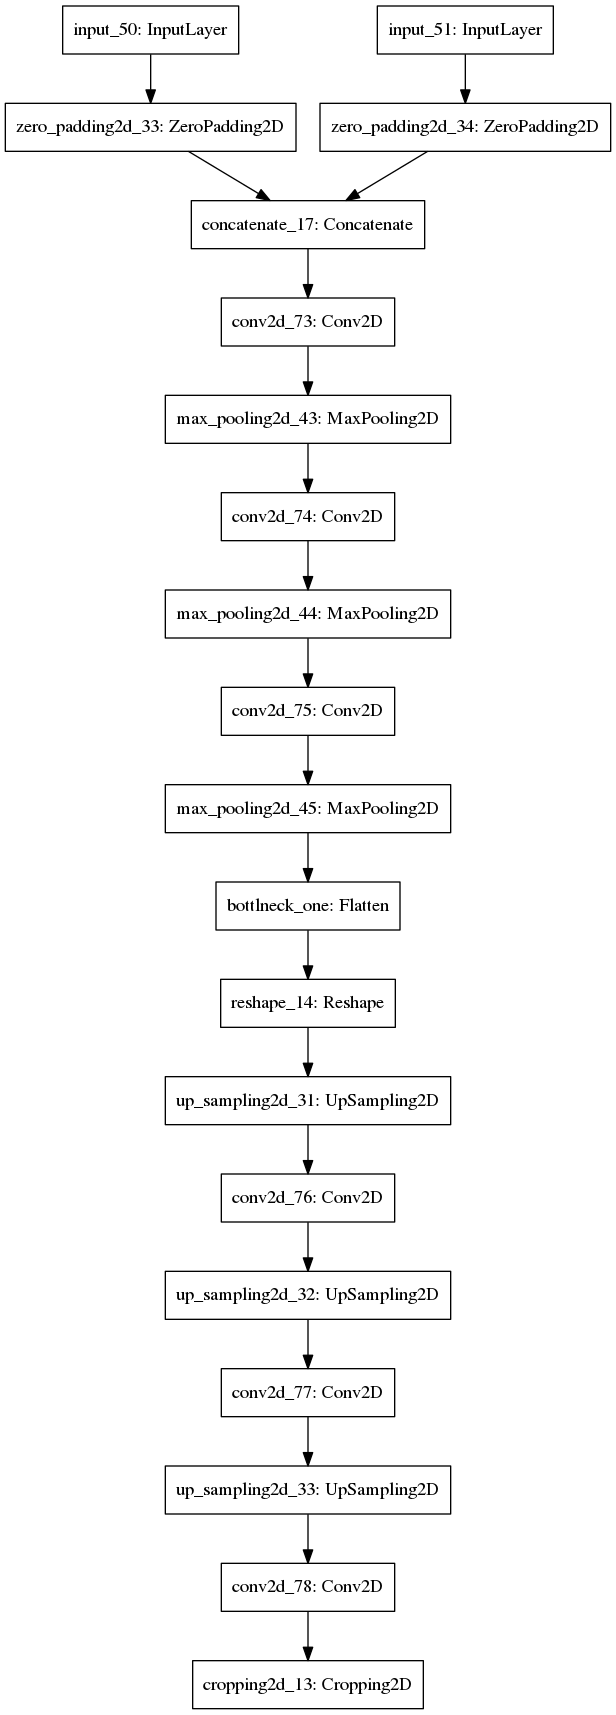

In [37]:
Image(retina=True, filename='model.png')

In [40]:
autopredictor.fit(x=[first_frame_x, second_frame_x],y=[frame_y], epochs=5) 

Epoch 1/5
997/997 [==============================] - 10s 10ms/step - loss: 0.0212
Epoch 2/5
997/997 [==============================] - 9s 9ms/step - loss: 0.0212
Epoch 3/5
997/997 [==============================] - 9s 9ms/step - loss: 0.0212
Epoch 4/5
997/997 [==============================] - 9s 9ms/step - loss: 0.0212
Epoch 5/5
997/997 [==============================] - 9s 9ms/step - loss: 0.0212


Max value of the distance: 0.7843137254901961
Max value of the prediction: 0.0


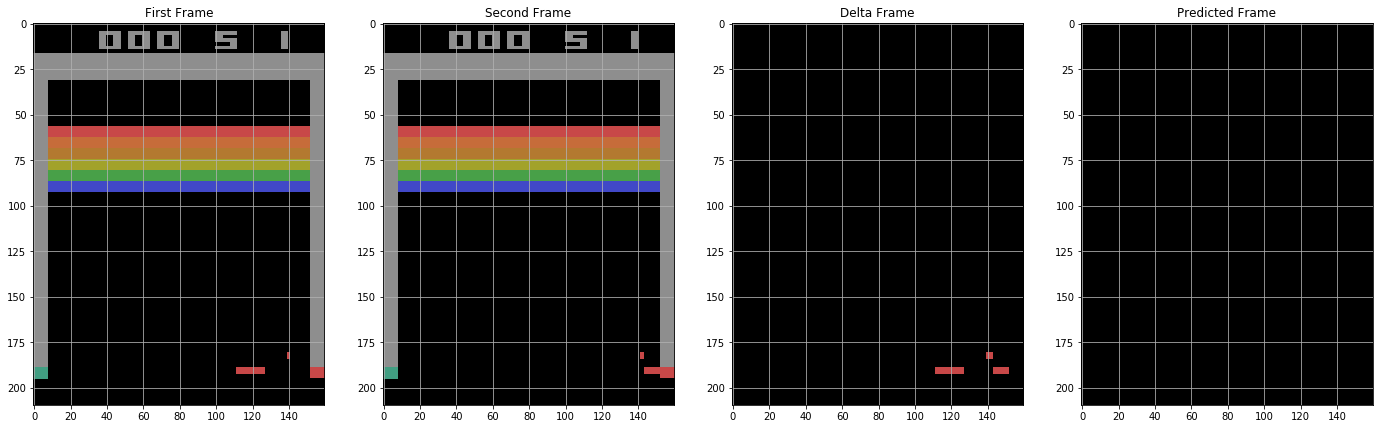

In [42]:
num = 12
print("Max value of the distance:", np.max(frame_y[0:1]))
print("Max value of the prediction:", np.max(list(autopredictor.predict([[first_frame_x[frame_to_show]],[second_frame_x[frame_to_show]]]).squeeze())))

fig=plt.figure(figsize=(24, 12))
ax = plt.subplot(1, 4, 1)
plt.imshow(first_frame_x[num])
plt.title("First Frame")
plt.grid()

ax = plt.subplot(1, 4, 2)
plt.title("Second Frame")
plt.imshow(second_frame_x[num])
plt.grid()

ax = plt.subplot(1, 4, 3)
plt.title("Delta Frame")
plt.imshow(frame_y[num])
plt.grid()

ax = plt.subplot(1, 4, 4)
plt.title("Predicted Frame")
plt.imshow((autopredictor.predict([first_frame_x[num:num+1],second_frame_x[num:num+1]]).squeeze()))
plt.grid()


# Nature CNN PreTrain

The max and min value of the x_train are: 0.580392156862745 0.0
(84, 84, 1)
The training shape: (2000, 84, 84, 1)


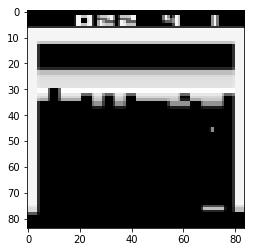

In [5]:
x_train = x_train * (1./255)

assert np.max(x_train) <= 1 and np.min(x_train) >= 0, "The normalization went wrong!"
# assert np.max(x_mem_train) <= 1 and np.min(x_mem_train) >= 0, "The normalization went wrong!"
print("The max and min value of the x_train are:", np.max(x_train),np.min(x_train))

img = random.choice(x_train)
print(img.shape)
plt.imshow(img.squeeze(),  cmap='gray')
print("The training shape:", x_train.shape)
# print("The testing shape:", x_test.shape)

In [6]:
x_len = x_train.shape[0]
print(x_train[ :x_len - 4].shape)
print(x_train[1:x_len - 3].shape)
print(x_train[2:x_len - 2].shape)
print(x_train[3:x_len - 1].shape)

four_vec_stack = [x_train[ :x_len-4].squeeze(), 
                  x_train[1:x_len-3].squeeze(), 
                  x_train[2:x_len-2].squeeze(),
                  x_train[3:x_len-1].squeeze()]
# del x_train

four_vec_stack = np.stack(four_vec_stack, axis=-1)

print(four_vec_stack.shape)

(1996, 84, 84, 1)
(1996, 84, 84, 1)
(1996, 84, 84, 1)
(1996, 84, 84, 1)
(1996, 84, 84, 4)


In [6]:
# K.clear_session()
input_image = Input(shape=(84,84,1))  # adapt this if using `channels_first` image data format

x = layers.Conv2D(32, (8, 8), strides= 4, activation='tanh',)(input_image)
x = layers.Conv2D(64, (4, 4), strides= 2, activation='tanh')(x)
x = layers.Conv2D(64, (3, 3), strides= 1, activation='tanh')(x)
x = layers.Flatten(name="feature_extractor")(x)

dense_out = layers.Dense(512, activation="tanh")(x)
x = layers.Reshape((8, 8, 8))(dense_out)

x = layers.Conv2DTranspose(64, (3, 3), strides=1, activation='tanh',)(x)
x = layers.Conv2DTranspose(64, (4, 4), strides= 2, activation='tanh')(x)
x = layers.Conv2DTranspose(1, (8, 8), strides= 4, activation='tanh')(x)

decoded = layers.Cropping2D(cropping=(4, 4))(x)

nature_cnn_feature = Model(inputs=input_image, outputs=decoded)
# nature_cnn_feature.compile(optimizer='Adam', loss='binary_crossentropy')
nature_cnn_feature.summary()
# autopredictor = Model(input_image, decoded)


  # compile method actually creates the model in the graph.
# with graph.as_default():
#   compile method actually creates the model in the graph.
# nature_cnn_feature.compile(optimizer='Adam', loss='binary_crossentropy')
# graph = tf.get_default_graph()
# writer = tf.summary.FileWriter(logdir='logs/keras', graph=graph)
# writer.flush()

# nature_cnn_feature.save("uncompiled_nature_cnn.h5")

# autopredictor.summary()

# plot_model(autopredictor)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 84, 84, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 20, 32)        2080      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
feature_extractor (Flatten)  (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1606144   
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 8)           0         
__________

In [6]:
# K.clear_session()
# tf.reset_default_graph()
feature_extractor = keras.models.load_model("uncompiled_nature_cnn.h5",compile=False)
graph = tf.get_default_graph()
writer = tf.summary.FileWriter(logdir='logs/keras_loaded', graph=graph)
writer.flush()
exit()
feature_extractor.layers.pop(0)

sb_placeholder = tf.placeholder(shape=(None, 84,84,4), dtype=tf.float32)

new_inputs = keras.layers.Input(tensor=sb_placeholder)

new_outputs = feature_extractor(new_inputs)

sb_model = keras.models.Model(new_inputs, new_outputs)


sb_model.summary()
graph = tf.get_default_graph()
writer = tf.summary.FileWriter(logdir='logs/keras2', graph=graph)
writer.flush()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 84, 84, 4)         0         
_________________________________________________________________
model_1 (Model)              (None, 512)               1684128   
Total params: 1,684,128
Trainable params: 1,684,128
Non-trainable params: 0
_________________________________________________________________


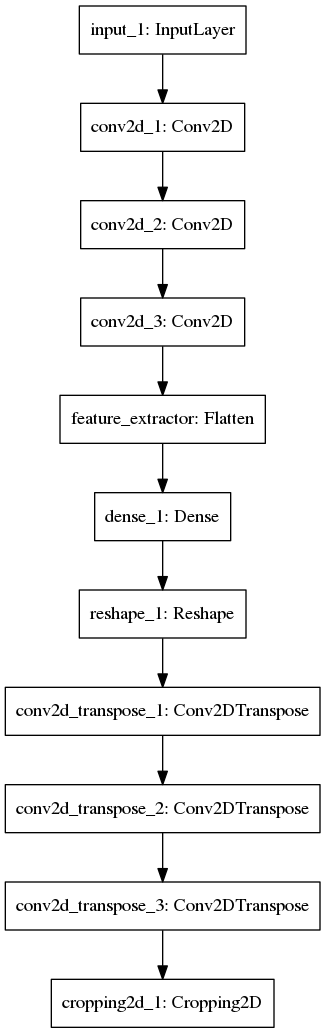

In [8]:
Image(retina=True, filename='model.png')

In [7]:
autopredictor.fit(x=x_train,y=x_train, validation_data=(x_test, x_test), epochs=5) 

NameError: name 'x_train' is not defined

In [19]:
autopredictor.fit(x=four_vec_stack, y=four_vec_stack[:,:,:,2:3],  validation_split=0.05, epochs=3) 

Train on 1896 samples, validate on 100 samples
Epoch 1/3
1896/1896 [==============================] - 2s 1ms/step - loss: 0.4225 - val_loss: 0.2854
Epoch 2/3
1896/1896 [==============================] - 1s 357us/step - loss: 0.2489 - val_loss: 0.2355
Epoch 3/3
1896/1896 [==============================] - 1s 355us/step - loss: 0.2284 - val_loss: 0.2304


In [7]:
four_vec_stack[:,:,:,3].shape

(1996, 84, 84)

(1996, 84, 84, 1)
(1996, 84, 84, 1)


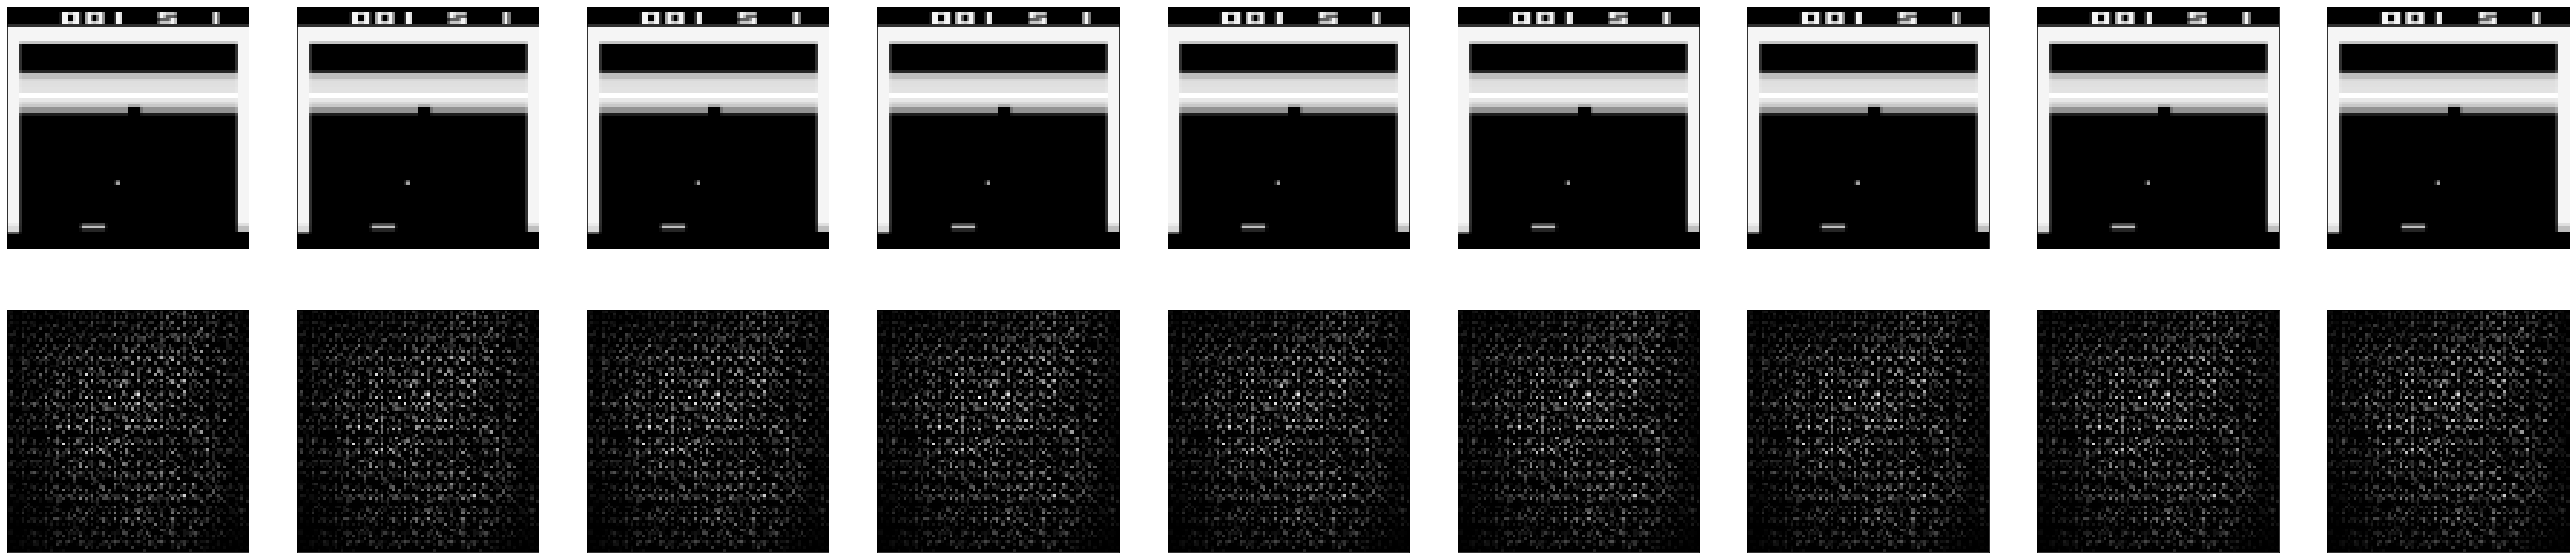

In [9]:
predict_start_state = 50
decoded_imgs = autopredictor.predict(four_vec_stack)
print(np.array(decoded_imgs).shape)
print(decoded_imgs.shape)
n = 10
plt.figure(figsize=(80, 16))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(four_vec_stack[:,:,:,3][predict_start_state:predict_start_state+10][0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(84, 84))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

(84, 84)


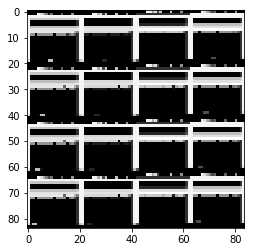

In [23]:
print(four_vec_stack[:,:,:,3][predict_start_state:predict_start_state+10][0].shape)
plt.imshow(four_vec_stack[:,:,:,3][predict_start_state:predict_start_state+10][0])


In [10]:
nature_cnn_feature.save("breakout_trained_nature_cnn_4_512.h5")
nature_cnn_feature.summary()
del nature_cnn_feature

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        8224      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
feature_extractor (Flatten)  (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1606144   
Total params: 1,684,128
Trainable params: 1,684,128
Non-trainable params: 0
_________________________________________________________________


In [24]:
feature_extractor = keras.models.load_model("breakout_trained_nature_cnn_4_512.h5")
sb_placeholder = tf.placeholder(shape=(None, 84,84,4), dtype=tf.float32)
input_sb_placeholder = keras.layers.Input(tensor=sb_placeholder)
input_linked_fe = feature_extractor(inputs=input_sb_placeholder)
sb_model = keras.models.Model(input_sb_placeholder, input_linked_fe)
sb_model.output

Tensor("dense_1/Relu:0", shape=(?, 512), dtype=float32)


/home/batu/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_1:0", shape=(?, 84, 84, 4), dtype=float32) at layer "input_1". The following previous layers were accessed without issue: []

In [1]:
import keras

Using TensorFlow backend.
